In [10]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "Kaiti",style="ticks",font_scale=1.8)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
## 导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing
import pmdarima as pm

from neuralprophet import NeuralProphet

In [2]:
usedatadf = pd.read_excel("附件1：赛题A数据.xlsx")
usedatadf.head()

时间     基站编号      小区编号  本地小区标识  上行可用的PRB个数  下行可用的PRB个数  \
0  2021-08-28 00:00  1200071  26019014       0         100         100   
1  2021-08-28 00:00  1200071  26019015       1         100         100   
2  2021-08-28 00:00  1200071  26019016       2         100         100   
3  2021-08-28 00:00  1200071  26019023       3         100         100   
4  2021-08-28 00:00  1200071  26019024       4         100         100   

   上行PhysicalResourceBlock被使用的平均个数  下行PhysicalResourceBlock被使用的平均个数  \
0                           6.4553                          31.5065   
1                           8.8281                          21.5452   
2                           5.5024                          11.9276   
3                           3.1113                           0.9637   
4                           2.6004                           1.0051   

   上行PUSCH的PhysicalResourceBlock被使用的平均个数  小区内的平均用户数  ...  \
0                                 2.1503    22.6341  ...   
1                                 4.2220    19.1064  ...   
2                                 1.8618    15.4729  ...   
3                                 0.0077     0.0509  ...   
4                                 0.1201     0.6355  ...   

   用户随机接入时TA值在区间11范围的接入次数  MR测量上报RSRP在Index0区间的次数  MR测量上报RSRP在Index1区间的次数  \
0                       0                       3                      16   
1                       0                       2                       4   
2                       0                       2                       4   
3                       0                       0                       0   
4                       0                       0                       1   

   MR测量上报RSRP在Index2区间的次数  MR测量上报RSRP在Index3区间的次数  MR测量上报RSRP在Index4区间的次数  \
0                      17                     178                    9943   
1                      21                     180                    8427   
2                      48                     575                    6371   
3                       0                       3                      31   
4                       1                       9                     285   

   小区QCI为1的DRB业务PDCPSDU上行丢弃的总包数包  小区QCI为1的DRB业务PDCPSDU上行期望收到的总包数  \
0                              0                            2218   
1                              0                            1510   
2                              0                            2030   
3                              0                               0   
4                              0                            7526   

   小区QCI为1的DRB业务PDCPSDU下行空口丢弃的总包数  小区QCI为1的DRB业务PDCPSDU下行空口发送的总包数  
0                               0                            2179  
1                               0                            1423  
2                               0                            1919  
3                               0                               0  
4                               0                            7780  

[5 rows x 71 columns]

In [3]:
## 数据提取,获取区内的平均用户数数据，指标1
usenumdf = usedatadf.iloc[:,0:4]
usenumdf["number"] = usedatadf["小区内的平均用户数"]
usenumdf["时间"] = pd.to_datetime(usenumdf["时间"],format = "%Y-%m-%d %H:%M")
usenumdf.head()

时间     基站编号      小区编号  本地小区标识   number
0 2021-08-28  1200071  26019014       0  22.6341
1 2021-08-28  1200071  26019015       1  19.1064
2 2021-08-28  1200071  26019016       2  15.4729
3 2021-08-28  1200071  26019023       3   0.0509
4 2021-08-28  1200071  26019024       4   0.6355

In [4]:
## 以其中一个小区的某个指标数据为例，建立时间序列预测模型
## 针对某个小区，只使用时序数据的模型建立
tspredf =  usenumdf.loc[usenumdf["小区编号"] == 26019010,["时间","number"]]
tspredf 

时间  number
5     2021-08-28 00:00:00  5.4037
63    2021-08-28 01:00:00  4.4619
121   2021-08-28 02:00:00  4.4547
179   2021-08-28 03:00:00  3.6584
237   2021-08-28 04:00:00  3.9856
...                   ...     ...
40083 2021-09-25 19:00:00  4.1742
40141 2021-09-25 20:00:00  2.8317
40199 2021-09-25 21:00:00  3.4589
40257 2021-09-25 22:00:00  4.3297
40315 2021-09-25 23:00:00  2.9381

[696 rows x 2 columns]

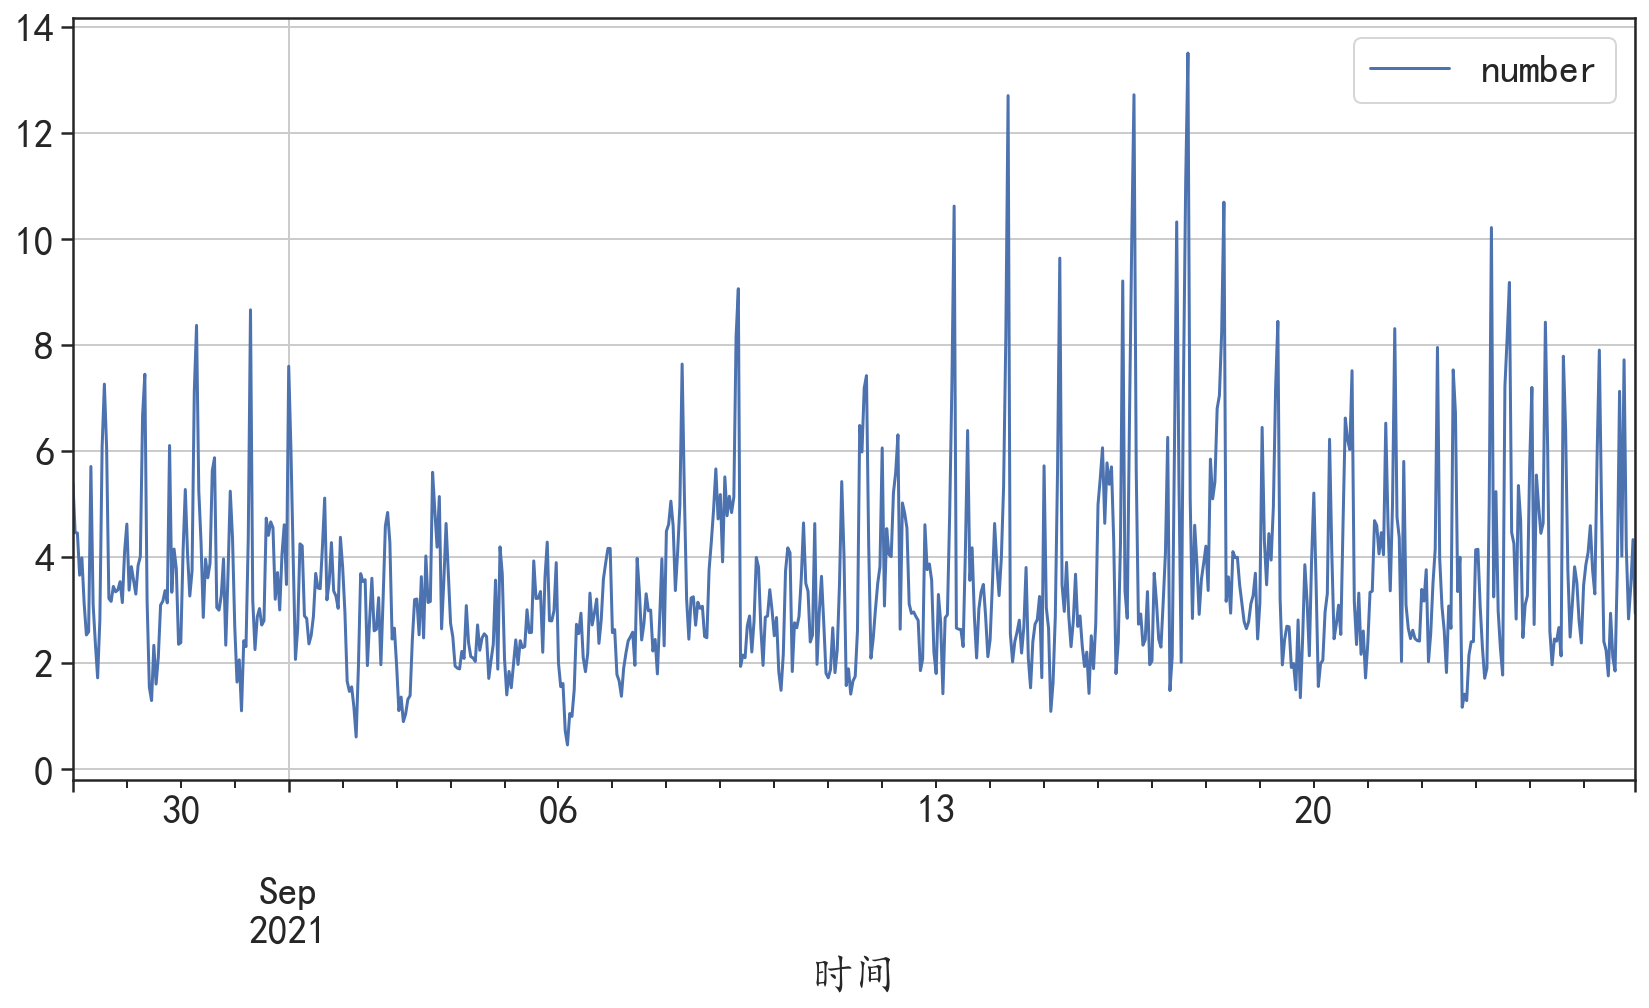

In [5]:
tspredf.plot(kind = "line",x = "时间",y = "number",figsize = (14,7))
plt.grid()
plt.show()

In [6]:
## 针对第一问检测出来的异常值数据，在进行第三问分析之前，可以对其进行一写处理后，在建模。这里对异常值的处理方式，这里就不再展示了。可自行发挥。当然不处理也是可以的。

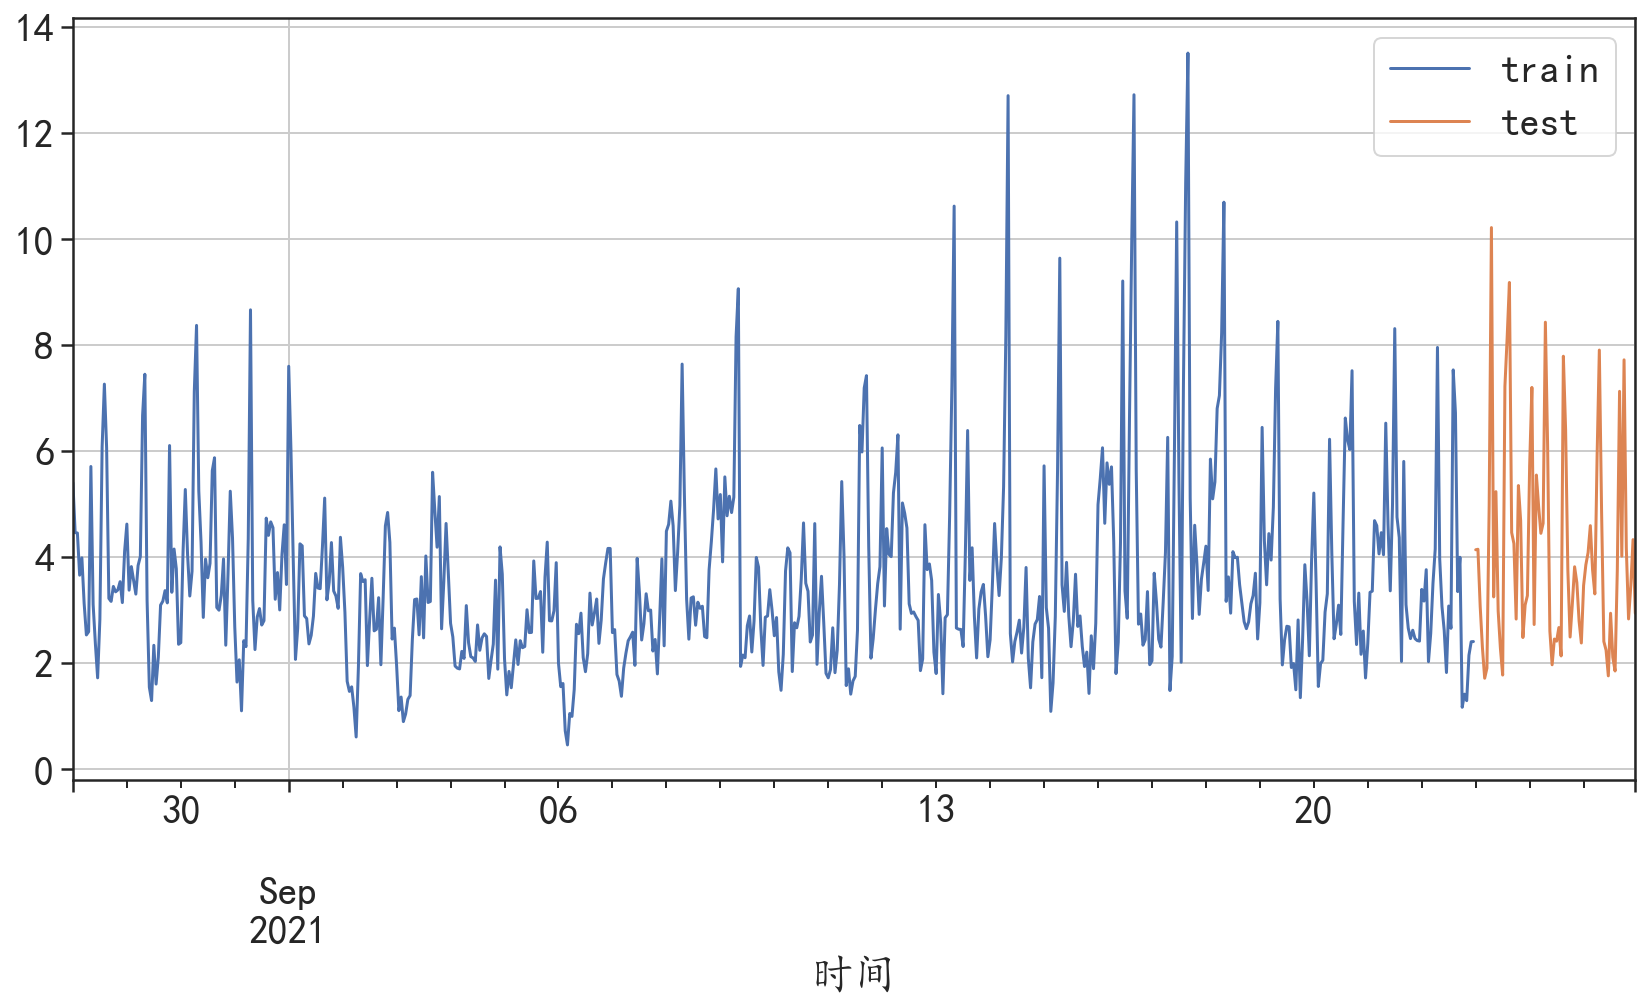

In [7]:
## 对序列进行切分，后面的3天的数据用于测试集
train = pd.DataFrame(tspredf[0:len(tspredf) - 72])
test = pd.DataFrame(tspredf[len(tspredf) - 72:])
## 可视化切分后的数据
fig = plt.figure()
ax = fig.add_subplot(111)
train.plot(figsize=(14,7), x = "时间",y = "number",label = "train",ax = ax)
test.plot(x = "时间",y = "number",label = "test",ax = ax)
plt.legend()
plt.grid()
plt.show()

In [8]:
train.head()

时间  number
5   2021-08-28 00:00:00  5.4037
63  2021-08-28 01:00:00  4.4619
121 2021-08-28 02:00:00  4.4547
179 2021-08-28 03:00:00  3.6584
237 2021-08-28 04:00:00  3.9856

###  Holt-Winters季节性预测模型

WARNING - (py.warnings._showwarnmsg) - /Users/daitu/opt/anaconda3/envs/DataVis/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(



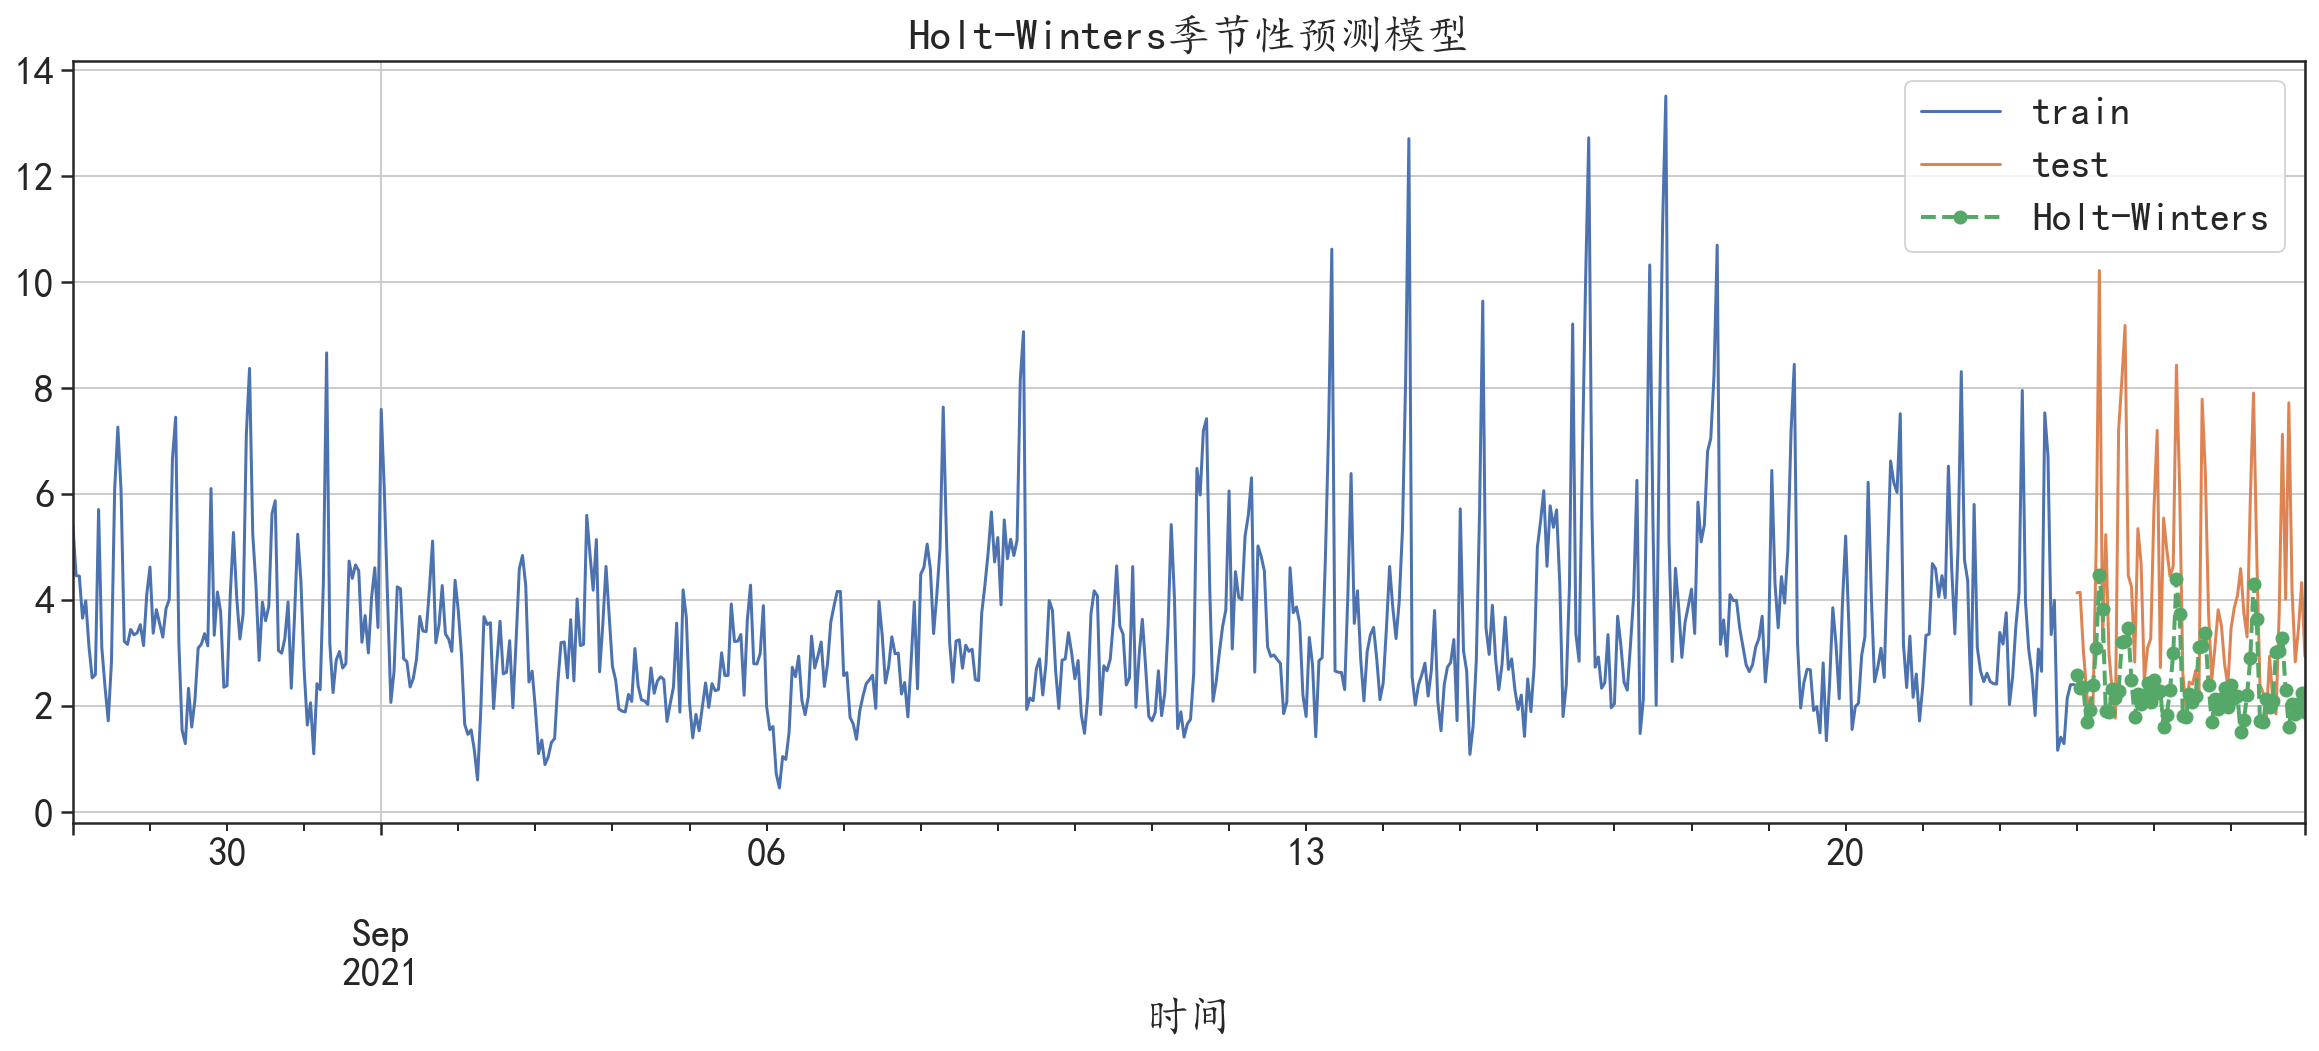

Holt-Winters季节性预测模型,预测绝对值误差: 1.8379957273145346


In [12]:
## 数据准备
y_hat_avg = test.copy(deep = False)
## 模型构建
model1 = ExponentialSmoothing(train["number"].values,
                              seasonal_periods=24, # 周期性为12  
                              trend="add", seasonal="add").fit()
y_hat_avg["holt_winter_forecast1"] = model1.forecast(len(test))

## 可视化出预测结果

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
train.plot(x = "时间",y = "number",label = "train",ax = ax)
test.plot(x = "时间",y = "number",label = "test",ax = ax)
y_hat_avg.plot(x = "时间",y = "holt_winter_forecast1",style="g--o", lw=2,label="Holt-Winters",ax = ax)
plt.legend()
plt.grid()
plt.title("Holt-Winters季节性预测模型")
plt.show()

## 计算预测结果和真实值的误差
print("Holt-Winters季节性预测模型,预测绝对值误差:",
      mean_absolute_error(test["number"],y_hat_avg["holt_winter_forecast1"]))

## 该模型的一数据的预测趋势是比较准确的

### SARIMA模型

In [13]:
## 针对模型自动寻找合适的参数
model = pm.auto_arima(train["number"].values,
                      start_p=1, start_q=1, # p,q的开始值
                      max_p=12, max_q=12, # 最大的p和q
                      test="kpss",       # 使用kpss检验确定d
                      d = None,          # 自动选择合适的d
                      m=24,               # 序列的周期
                      seasonal=True,         # 有季节性趋势
                      start_P = 0,start_Q = 0, # P,Q的开始值
                      max_P=5, max_Q=5,      # 最大的P和Q
                      D = None,              # 自动选择合适的D
                      trace=True,error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=2253.224, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=2404.387, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=2364.362, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=2341.661, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=2402.392, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=2222.066, Time=1.40 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=inf, Time=8.14 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=9.81 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=2366.020, Time=0.39 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=2216.495, Time=2.41 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=2240.831, Time=0.34 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=2218.164, Time=2.52 sec
 ARIMA(2,1,1)(0,0,2)[24] intercept   : 

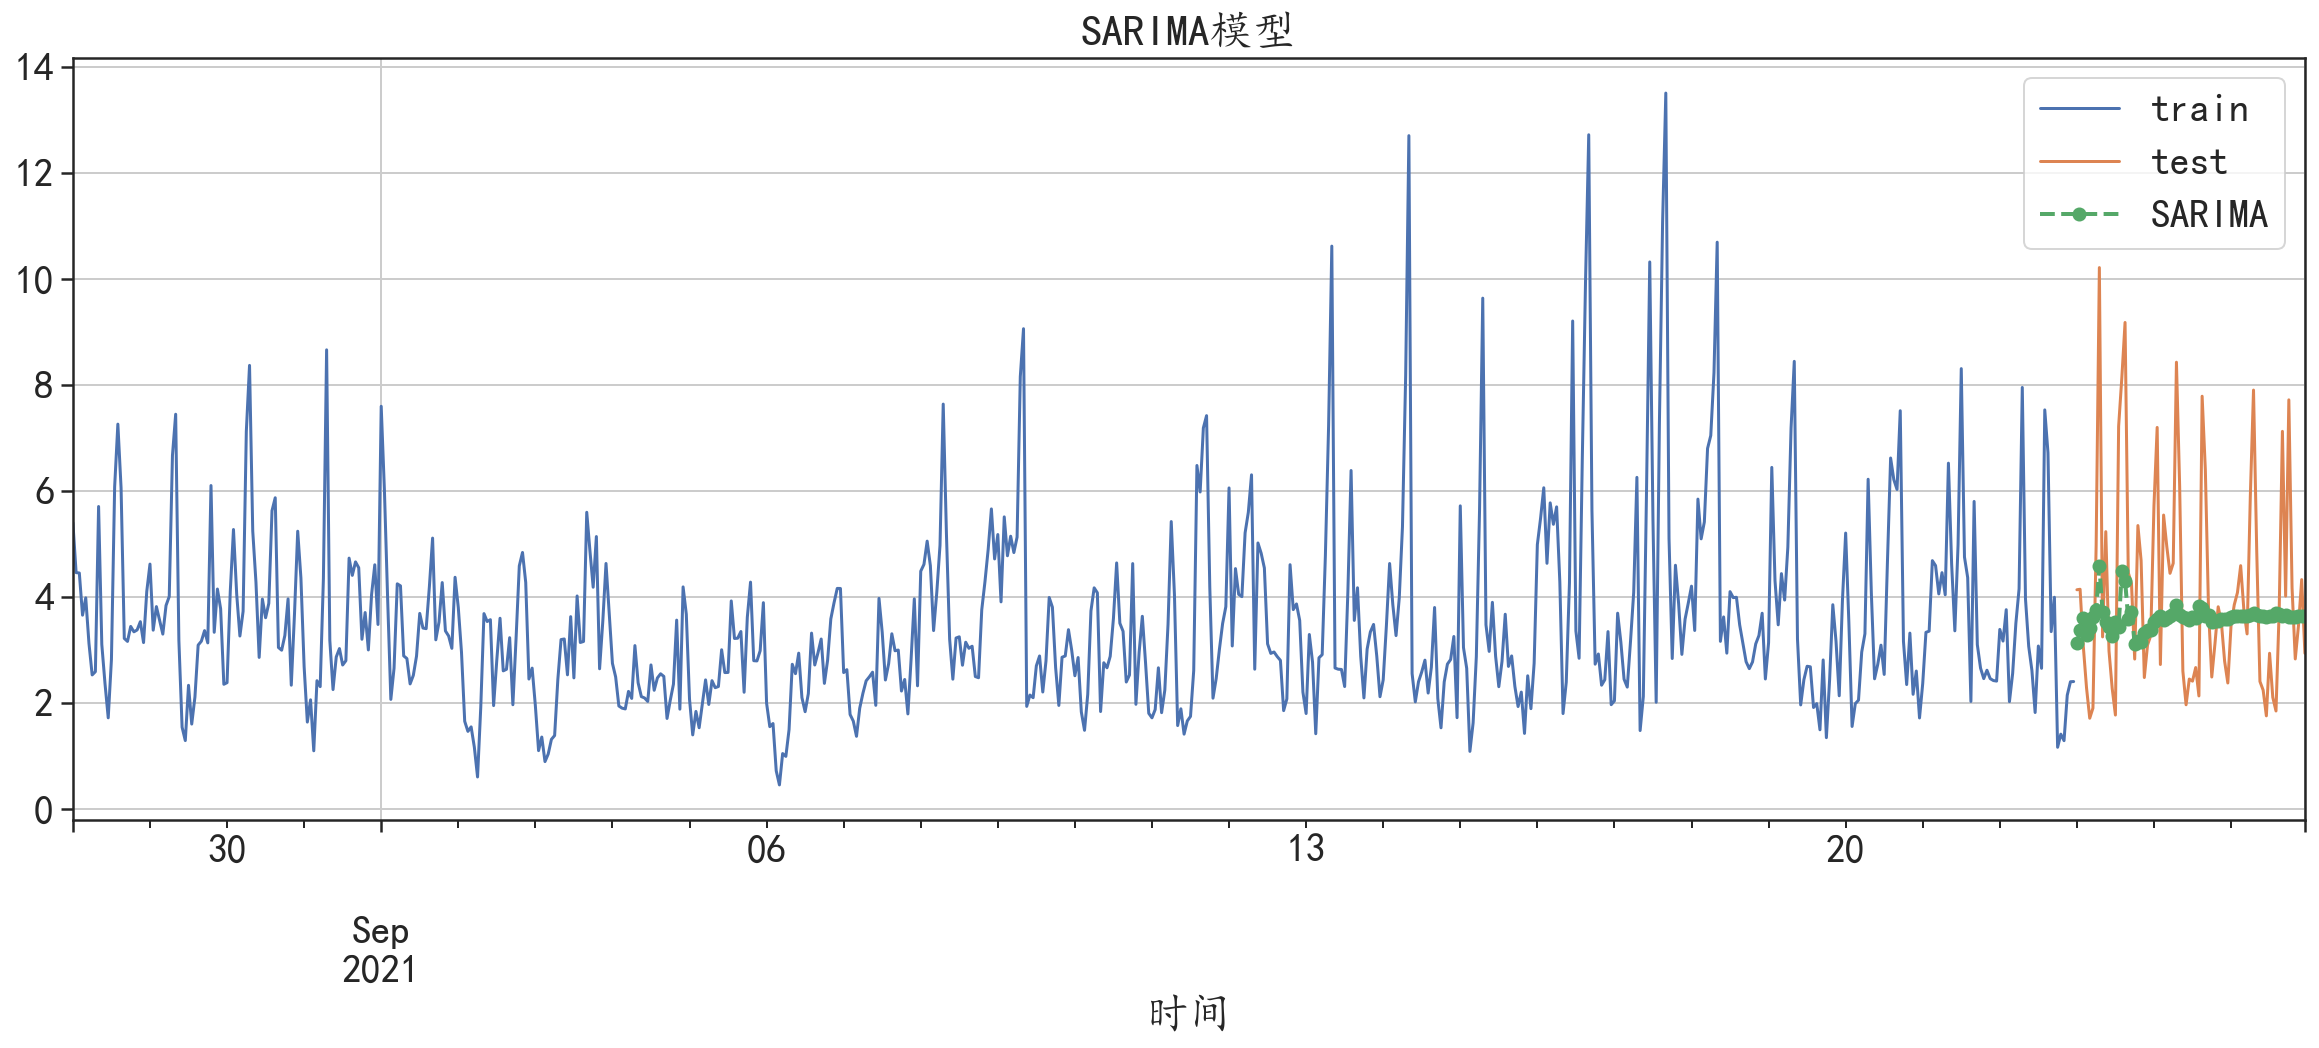

SARIMA模型预测的绝对值误差: 1.4511879115107276


In [14]:
## 可视化自动搜索参数获得的SARIMA(1,1,2)(1,0,0)[24] 对测试集进行预测
pre, conf = model.predict(n_periods=72, alpha=0.05,
                          return_conf_int=True)
## 可视化SARIMA(1,1,2)(1,0,0)[24] 的预测结果，整理数据
y_hat = test.copy(deep = False)
y_hat["sarima_pre"] = pre
y_hat["sarima_pre_lower"] = conf[:,0]
y_hat["sarima_pre_upper"] = conf[:,1]
## 可视化出预测结果
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
train.plot(x = "时间",y = "number",ax = ax,label = "train")
test.plot(x = "时间",y = "number",ax = ax,label = "test")
y_hat.plot(x = "时间",y = "sarima_pre",ax = ax,style="g--o", lw=2,label="SARIMA")
plt.legend()
plt.grid()
plt.title("SARIMA模型")
plt.show()

# 计算预测结果和真实值的误差
print("SARIMA模型预测的绝对值误差:",
      mean_absolute_error(test["number"],y_hat["sarima_pre"]))

## 可以发现SARIMA模型很好的预测了算法的变化趋势，而且预测误差更小，但是预测的趋势更接近均值

### prophet时间序列预测

In [15]:
## 数据准备
tspredf.columns = ["ds","y"]
tspredf.head()

ds       y
5   2021-08-28 00:00:00  5.4037
63  2021-08-28 01:00:00  4.4619
121 2021-08-28 02:00:00  4.4547
179 2021-08-28 03:00:00  3.6584
237 2021-08-28 04:00:00  3.9856

In [16]:
## 对序列进行切分，后面的3天的数据用于测试集
train = pd.DataFrame(tspredf[0:len(tspredf) - 72])
test = pd.DataFrame(tspredf[len(tspredf) - 72:])

## 构建模型
model = Prophet(growth = "linear",   # 线性增长趋势
                yearly_seasonality = False, # 年周期的趋势
                weekly_seasonality = True,# 以周为周期的趋势
                daily_seasonality = True,  # 以天为周期的趋势
                seasonality_mode = "multiplicative", # 季节周期性模式
                seasonality_prior_scale = 24, # 季节周期性长度
               )
model.fit(train)
## 使用模型对测试集进行预测
forecast = model.predict(test)
## 输出部分预测结果
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("在测试集上绝对值预测误差为:",mean_absolute_error(test.y,forecast.yhat))

## 预测的绝对值误差更小

Initial log joint probability = -9.37053
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       1015.14    0.00110034       71.0964   1.455e-05       0.001      101  LS failed, Hessian reset 
      83       1015.37   0.000733942       77.4113   9.831e-06       0.001      194  LS failed, Hessian reset 
      99       1015.42   0.000109888       69.0816      0.7173           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       1015.42   2.66837e-05       69.4264   3.863e-07       0.001      248  LS failed, Hessian reset 
     131       1015.42   7.32202e-07       64.0033   1.265e-08       0.001      326  LS failed, Hessian reset 
     141       1015.42   8.54088e-08        63.823           1           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
                   ds      yhat  yhat_lower  yhat_u

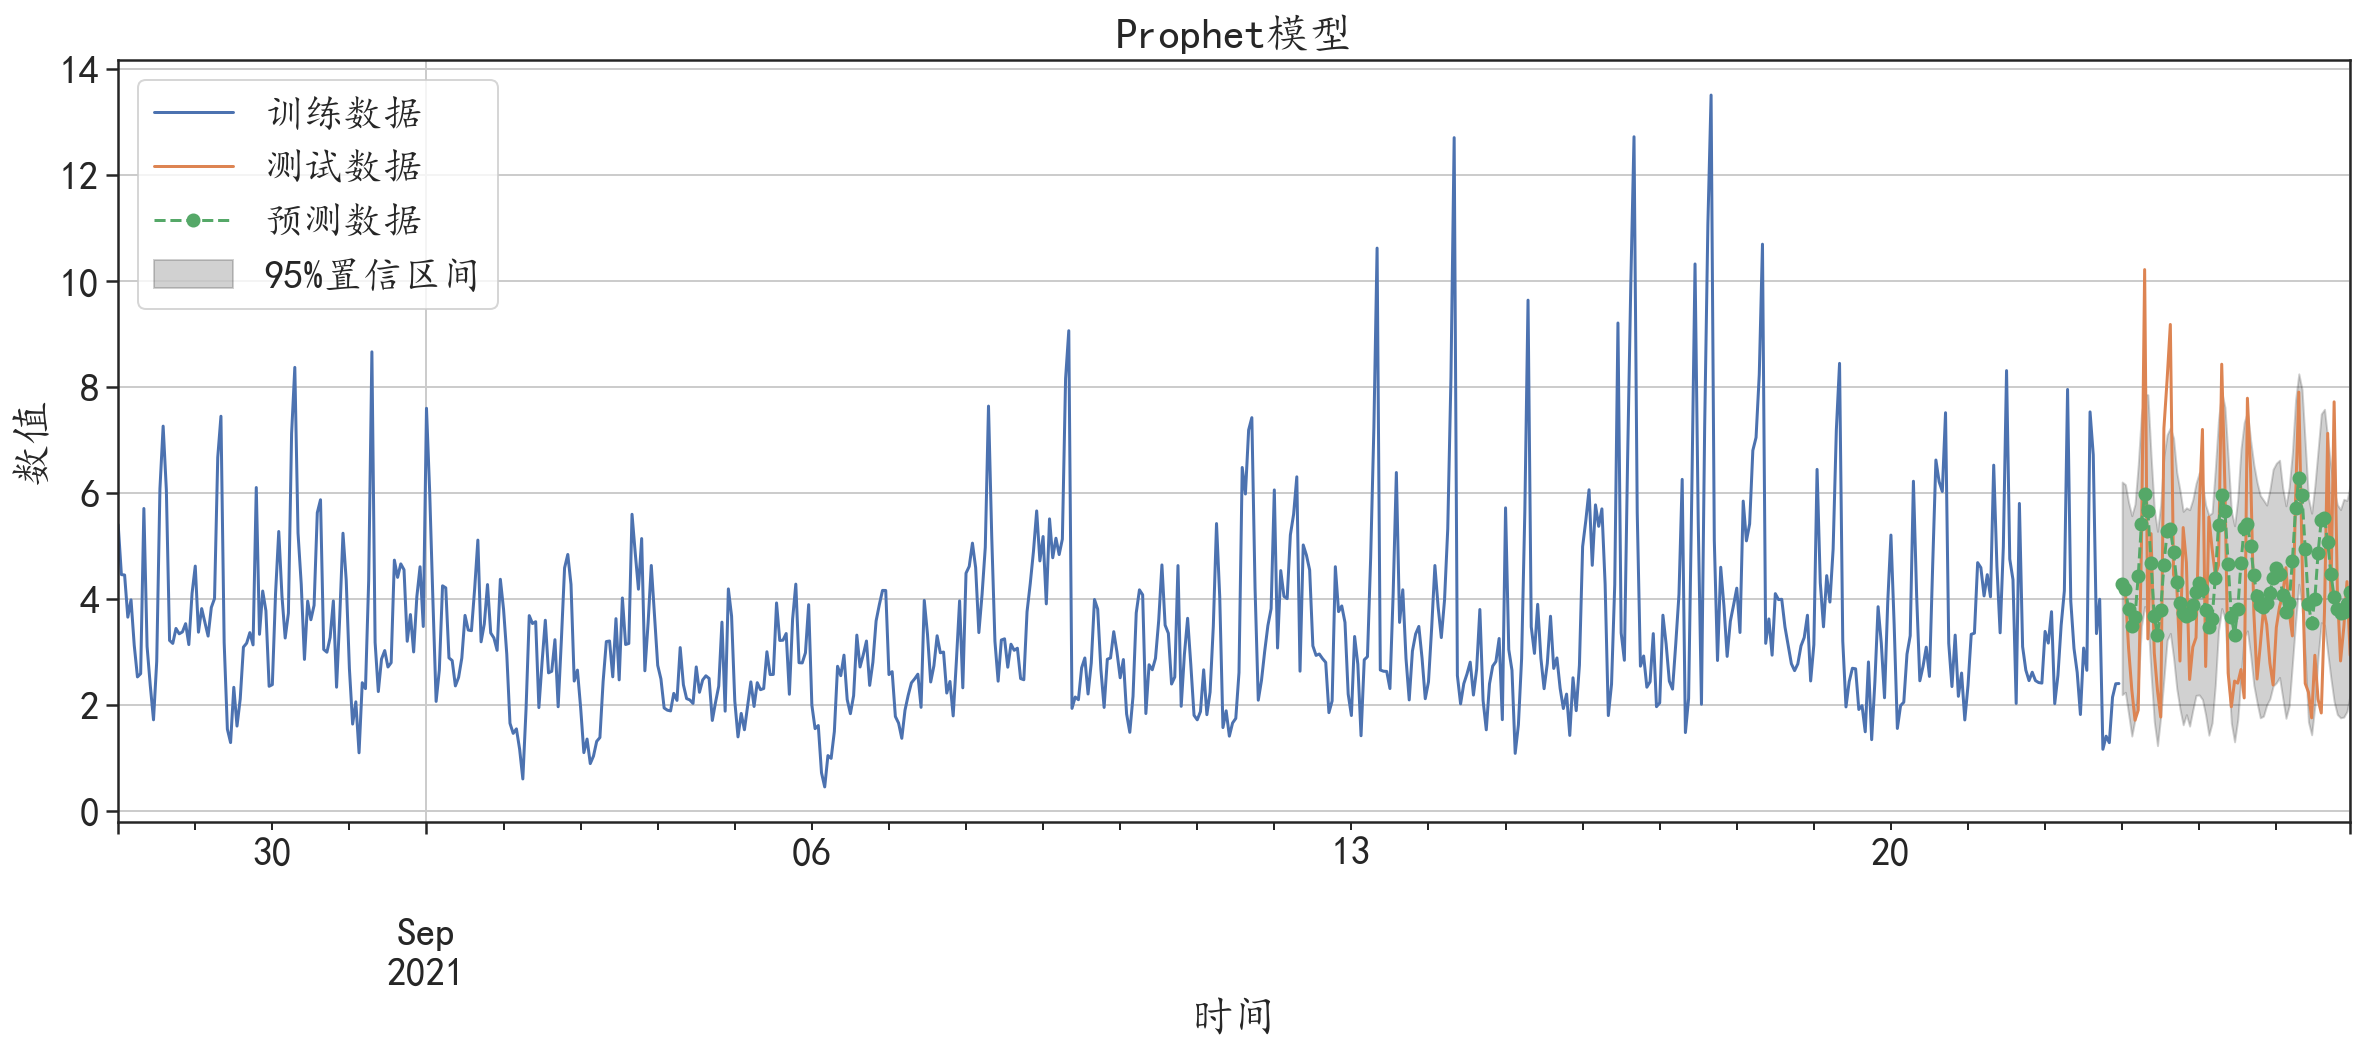

In [17]:
## 可视化原始数据和预测数据进行对比
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
train.plot(x = "ds",y = "y",label="训练数据",ax = ax)
test.plot(x = "ds",y = "y",label="测试数据",ax = ax)
forecast.plot(x = "ds",y = "yhat",style = "g--o",label="预测数据",ax = ax)
## 可视化出置信区间
ax.fill_between(test["ds"].values, forecast["yhat_lower"], 
                forecast["yhat_upper"],color='k',alpha=.2,
                label = "95%置信区间")
plt.grid()
plt.xlabel("时间")
plt.ylabel("数值")
plt.title("Prophet模型")
plt.legend(loc=2)
plt.show()


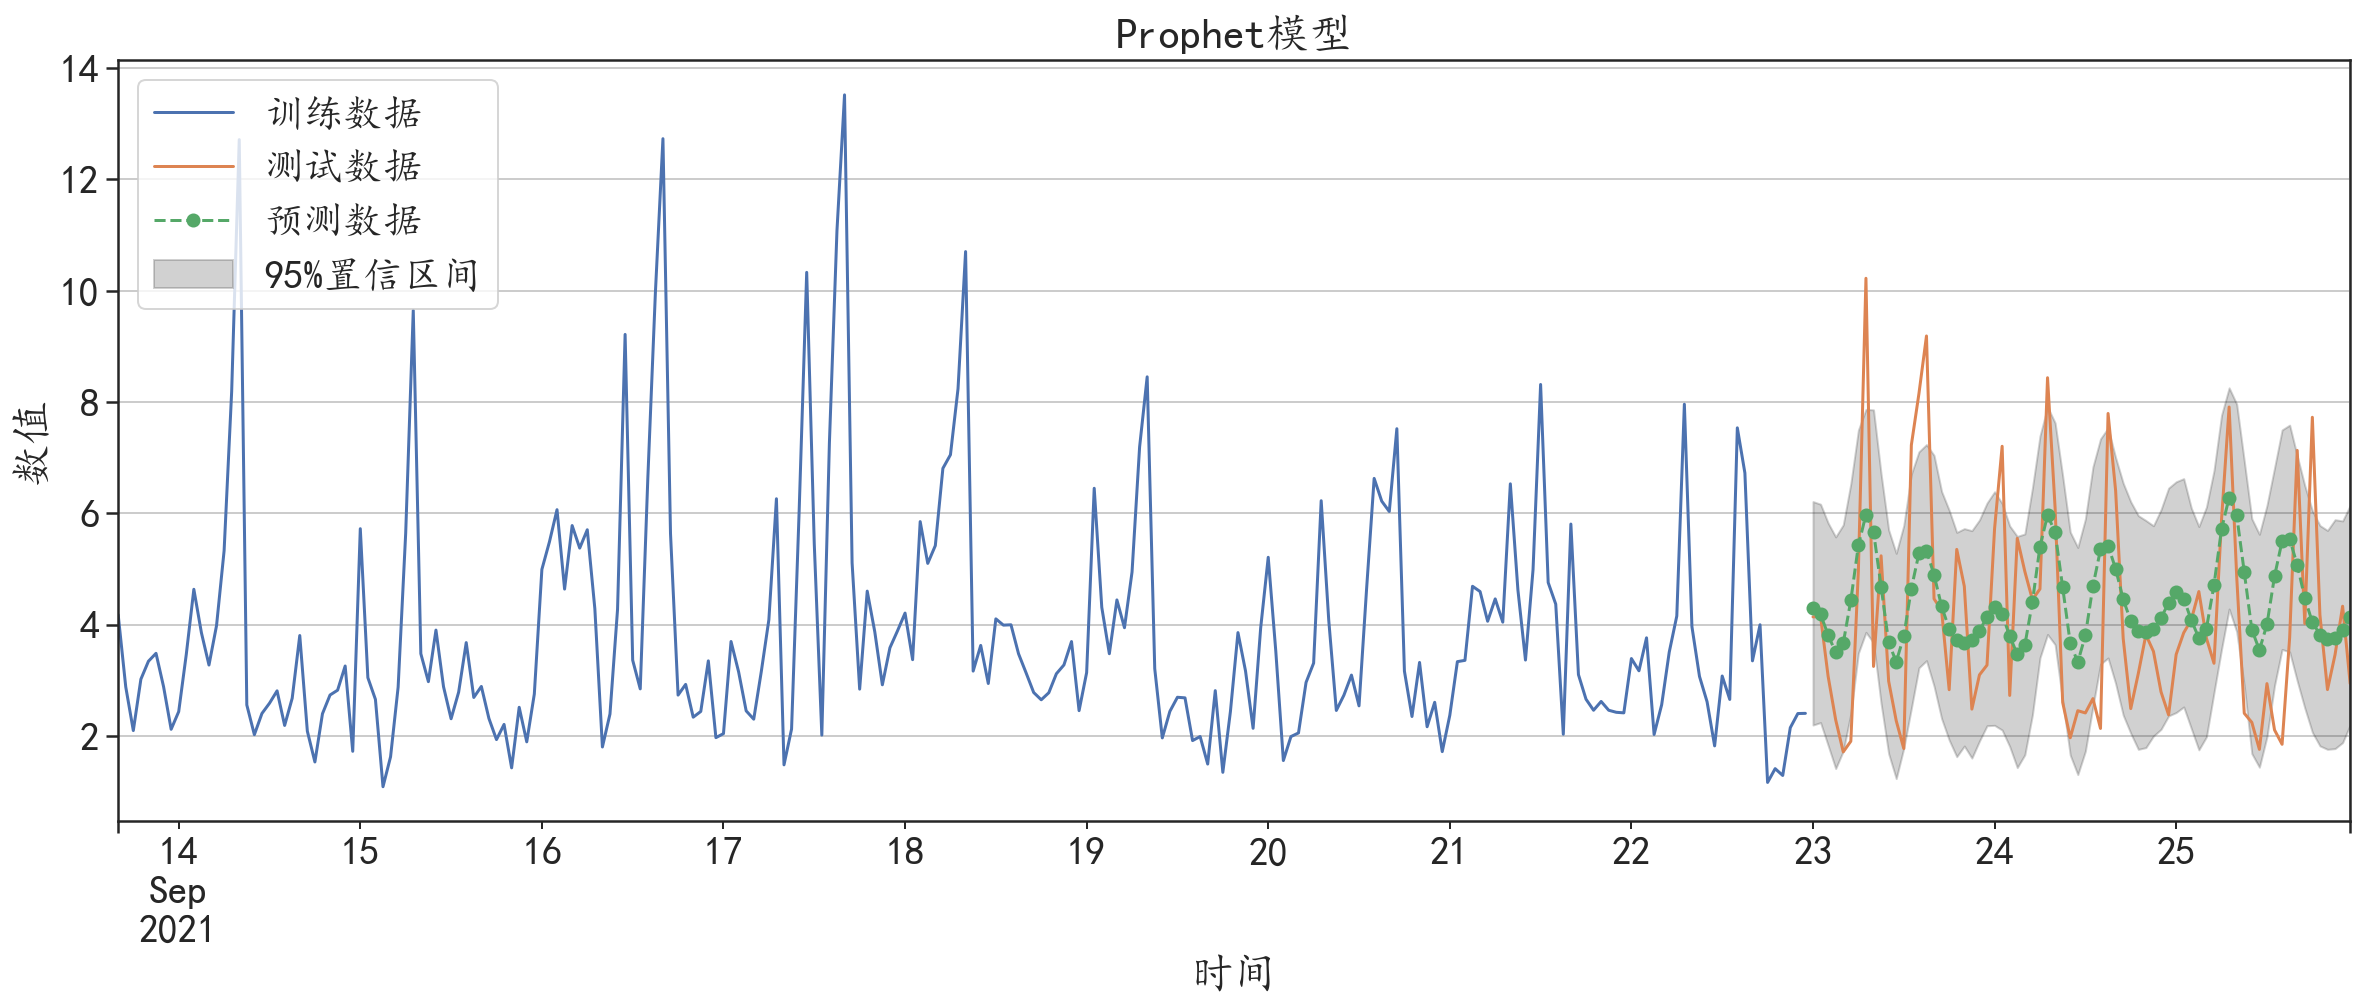

In [18]:
## 可视化原始数据和预测数据进行对比,可视化更少的数据，观察更多的细节

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
train[400:].plot(x = "ds",y = "y",label="训练数据",ax = ax)
test.plot(x = "ds",y = "y",label="测试数据",ax = ax)
forecast.plot(x = "ds",y = "yhat",style = "g--o",label="预测数据",ax = ax)
## 可视化出置信区间
ax.fill_between(test["ds"].values, forecast["yhat_lower"], 
                forecast["yhat_upper"],color='k',alpha=.2,
                label = "95%置信区间")
plt.grid()
plt.xlabel("时间")
plt.ylabel("数值")
plt.title("Prophet模型")
plt.legend(loc=2)
plt.show()

## 无论是预测的趋势，还是预测效果，都是更好

In [19]:
## 以prophet时间序列预测算法为例预测未来的3天数据
## 构建模型
model = Prophet(growth = "linear",   # 线性增长趋势
                yearly_seasonality = False, # 年周期的趋势
                weekly_seasonality = True,# 以周为周期的趋势
                daily_seasonality = True,  # 以天为周期的趋势
                seasonality_mode = "multiplicative", # 季节周期性模式
                seasonality_prior_scale = 24, # 季节周期性长度
               )
model.fit(tspredf)
# ## 使用模型对测试集进行预测
future = model.make_future_dataframe(periods=72,freq = "H")
forecast = model.predict(future)

## 输出部分预测结果
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(80))

Initial log joint probability = -10.4101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1128.57   0.000520889       81.5787   6.791e-06       0.001      141  LS failed, Hessian reset 
      99        1128.6    2.2854e-05       65.7833      0.2029      0.6006      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1128.73   9.80763e-05       62.8765      0.3989           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1128.97    0.00132734       81.7475      0.4765      0.4765      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303          1129   0.000325407       92.5248    4.52e-06       0.001      459  LS failed, Hessian reset 
     384       1129.16   9.17849e-07       73.5532   1.172e-08       0.001      606  LS failed, Hessian rese

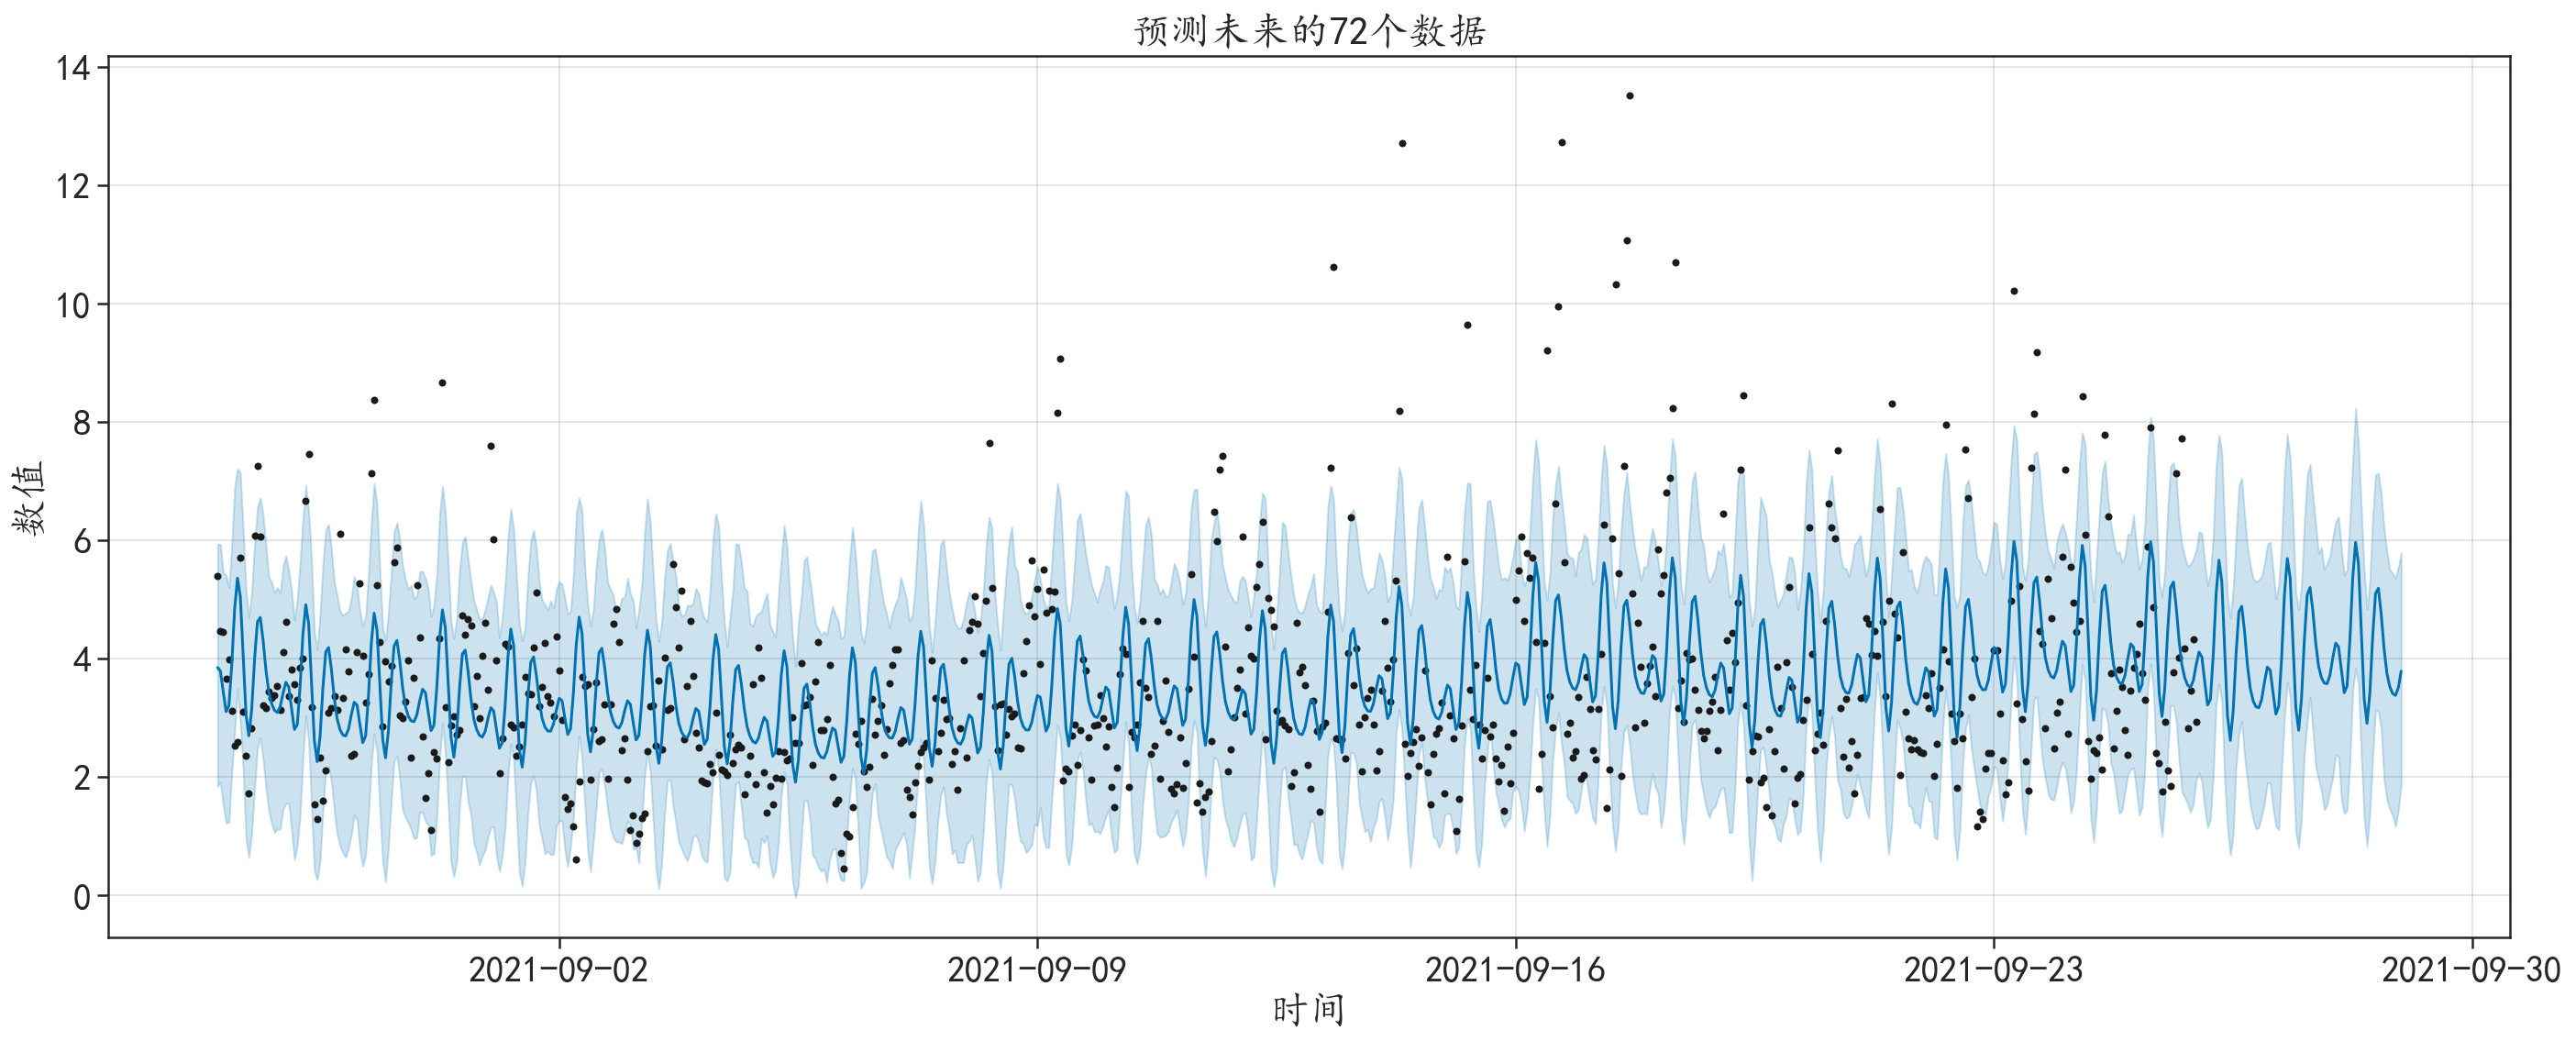

In [20]:
## 可视化预测结果
model.plot(forecast,figsize=(20,8),xlabel = "时间", ylabel = "数值")
plt.title("预测未来的72个数据")
plt.show()

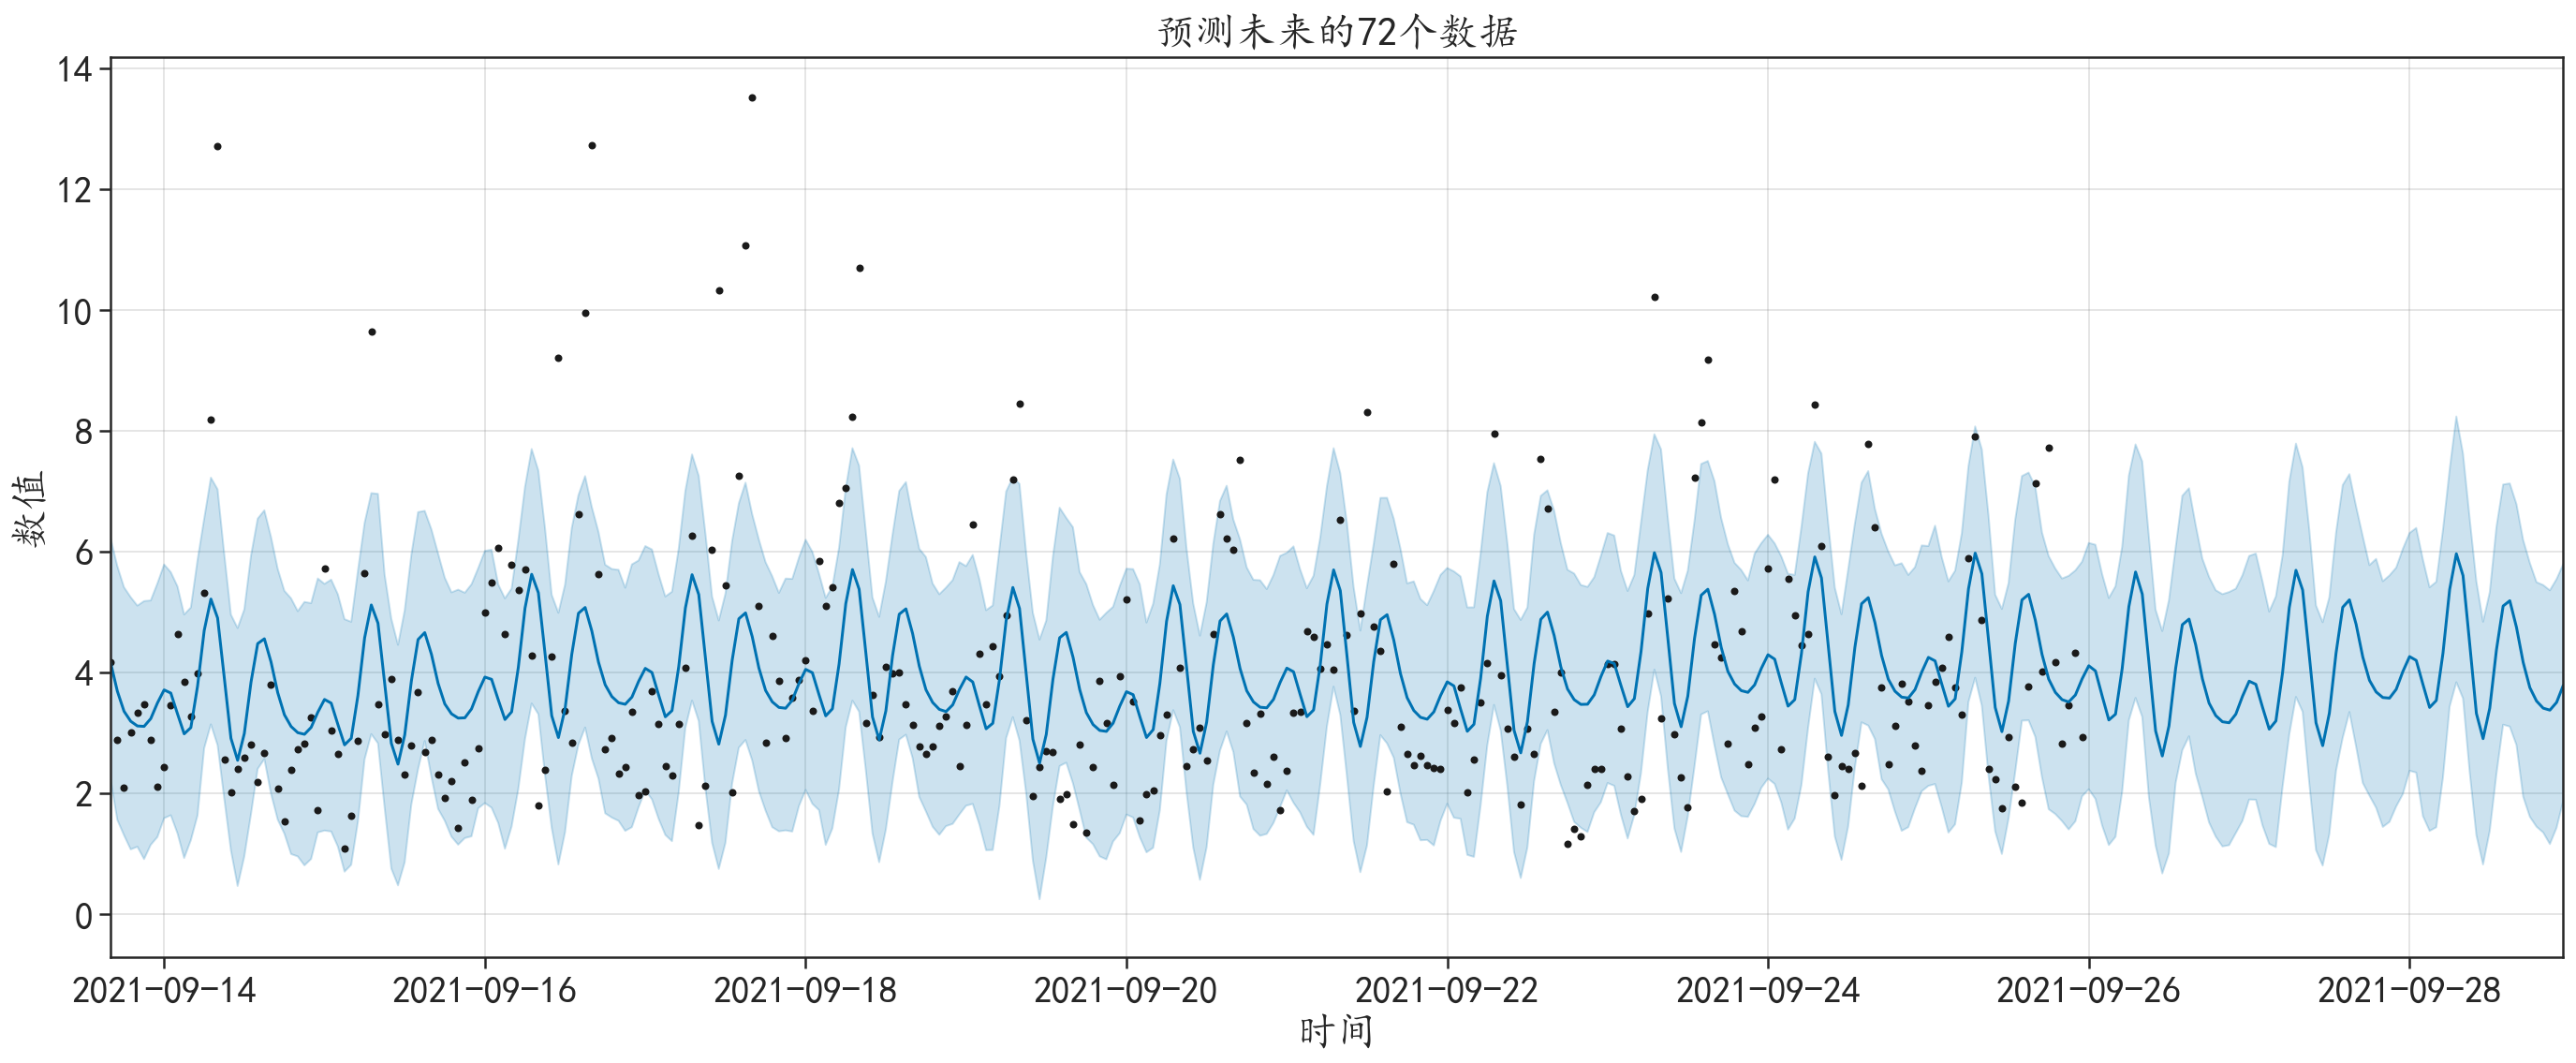

In [21]:
## 可视化预测结果,可视化更多的细节
model.plot(forecast,figsize=(20,8),xlabel = "时间", ylabel = "数值")
plt.xlim([forecast.ds.values[400],forecast.ds.values[-1]])
plt.title("预测未来的72个数据")
plt.show()

### 换一个小区的数据用于演示

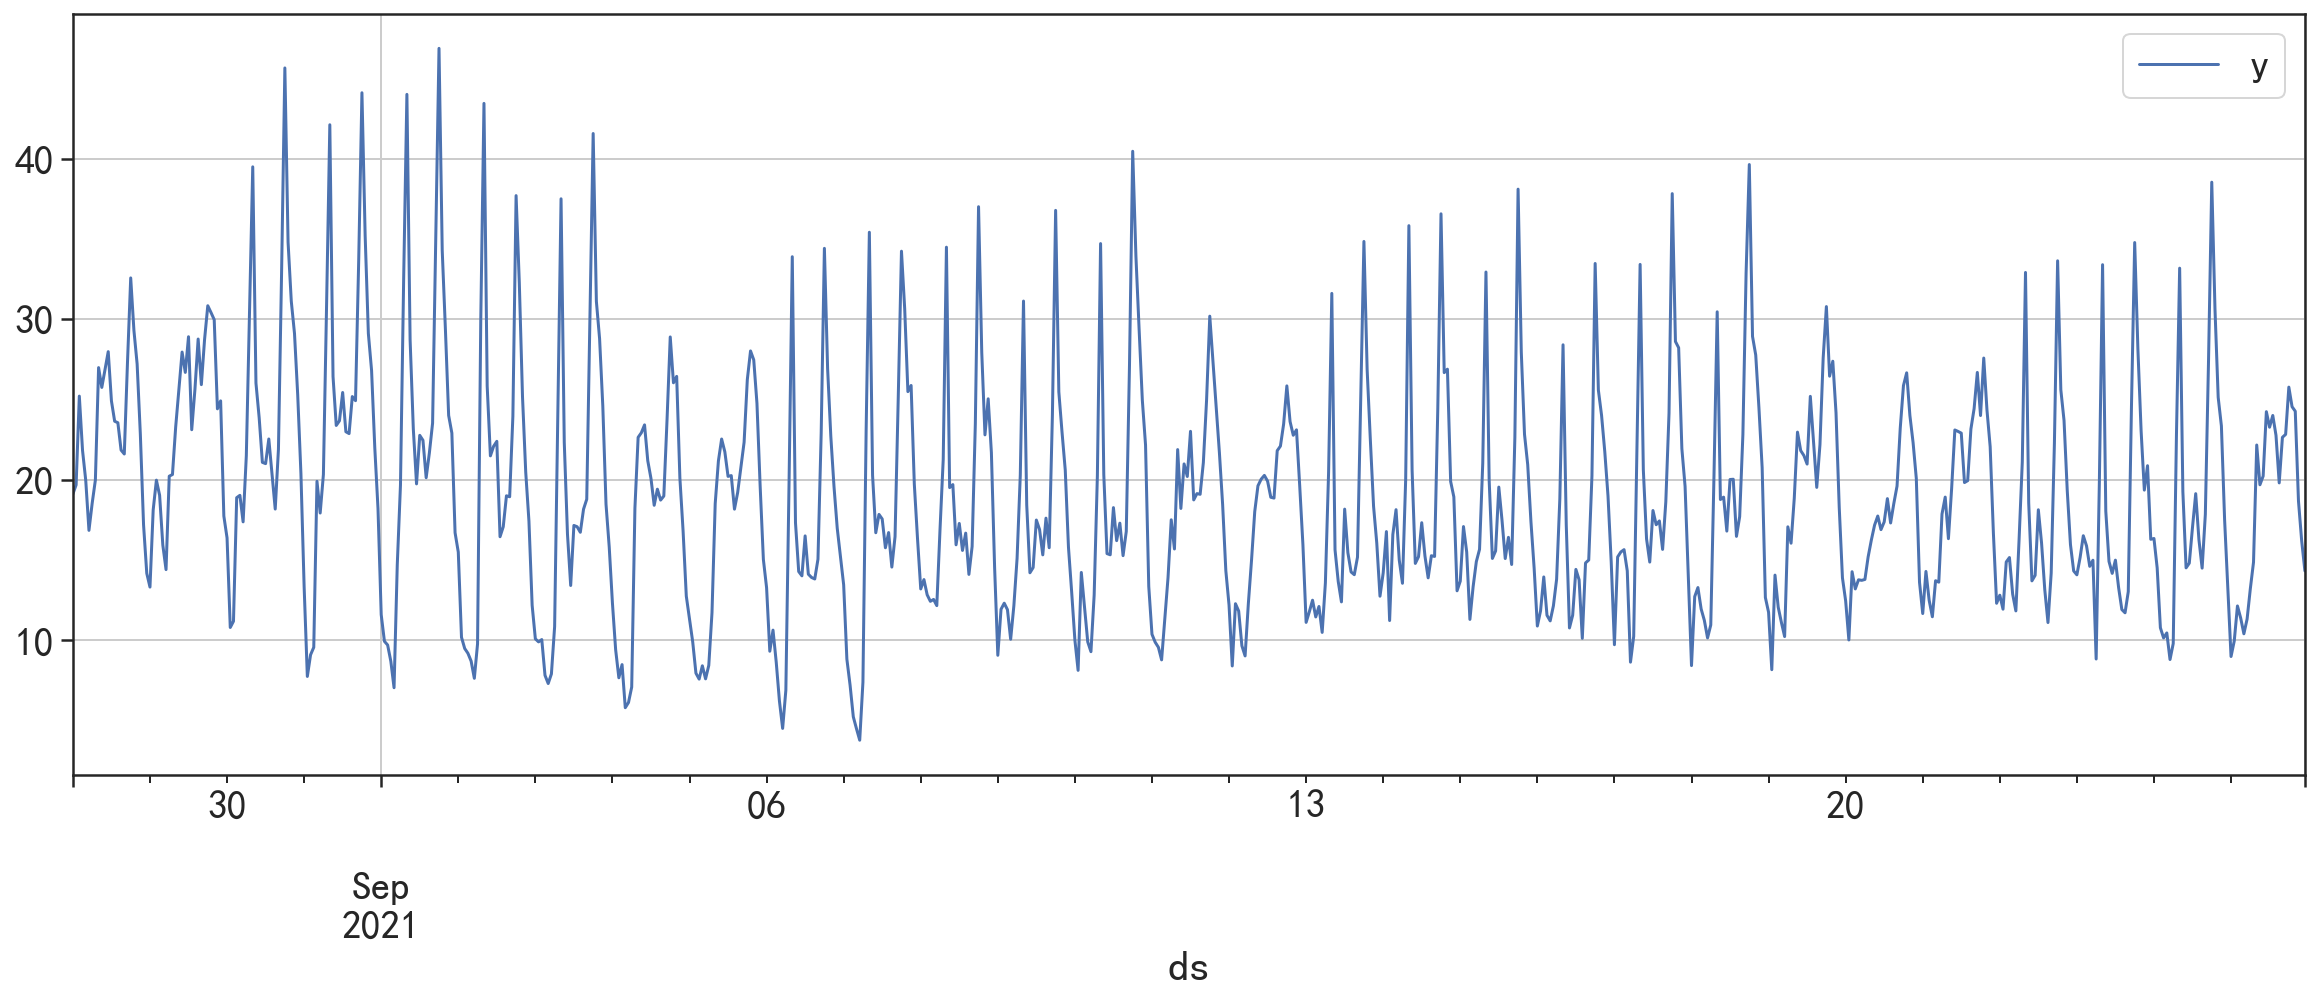

In [22]:
## 以其中一个小区的某个指标数据为例，建立时间序列预测模型
## 针对某个小区，只使用时序数据的模型建立
tspredf =  usenumdf.loc[usenumdf["小区编号"] == 26019015,["时间","number"]]
tspredf.columns = ["ds","y"]
tspredf.plot(kind = "line",x = "ds",y = "y",figsize = (20,7))
plt.grid()
plt.show()

In [23]:
## 以prophet时间序列预测算法为例预测未来的3天数据
## 构建模型
model = Prophet(growth = "linear",   # 线性增长趋势
                yearly_seasonality = False, # 年周期的趋势
                weekly_seasonality = True,# 以周为周期的趋势
                daily_seasonality = True,  # 以天为周期的趋势
                seasonality_mode = "multiplicative", # 季节周期性模式
                seasonality_prior_scale = 24, # 季节周期性长度
               )
model.fit(tspredf)
# ## 使用模型对测试集进行预测
future = model.make_future_dataframe(periods=72,freq = "H")
forecast = model.predict(future)

## 输出部分预测结果
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(80))

Initial log joint probability = -11.2895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1344.47   0.000167263       84.0167      0.2923      0.6921      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       1344.49   5.16921e-08       80.2631      0.6465      0.6465      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
                     ds       yhat  yhat_lower  yhat_upper
688 2021-09-25 16:00:00  19.954437   14.689365   25.164268
689 2021-09-25 17:00:00  24.093066   19.152363   29.157424
690 2021-09-25 18:00:00  28.051286   22.633063   32.853257
691 2021-09-25 19:00:00  29.274935   23.777272   34.328636
692 2021-09-25 20:00:00  26.506308   21.241418   31.626782
..                  ...        ...         ...         ...
763 2021-09-28 19:00:00  30.803077   25.253767   35.678457
764 2021-09-28 20:00:00

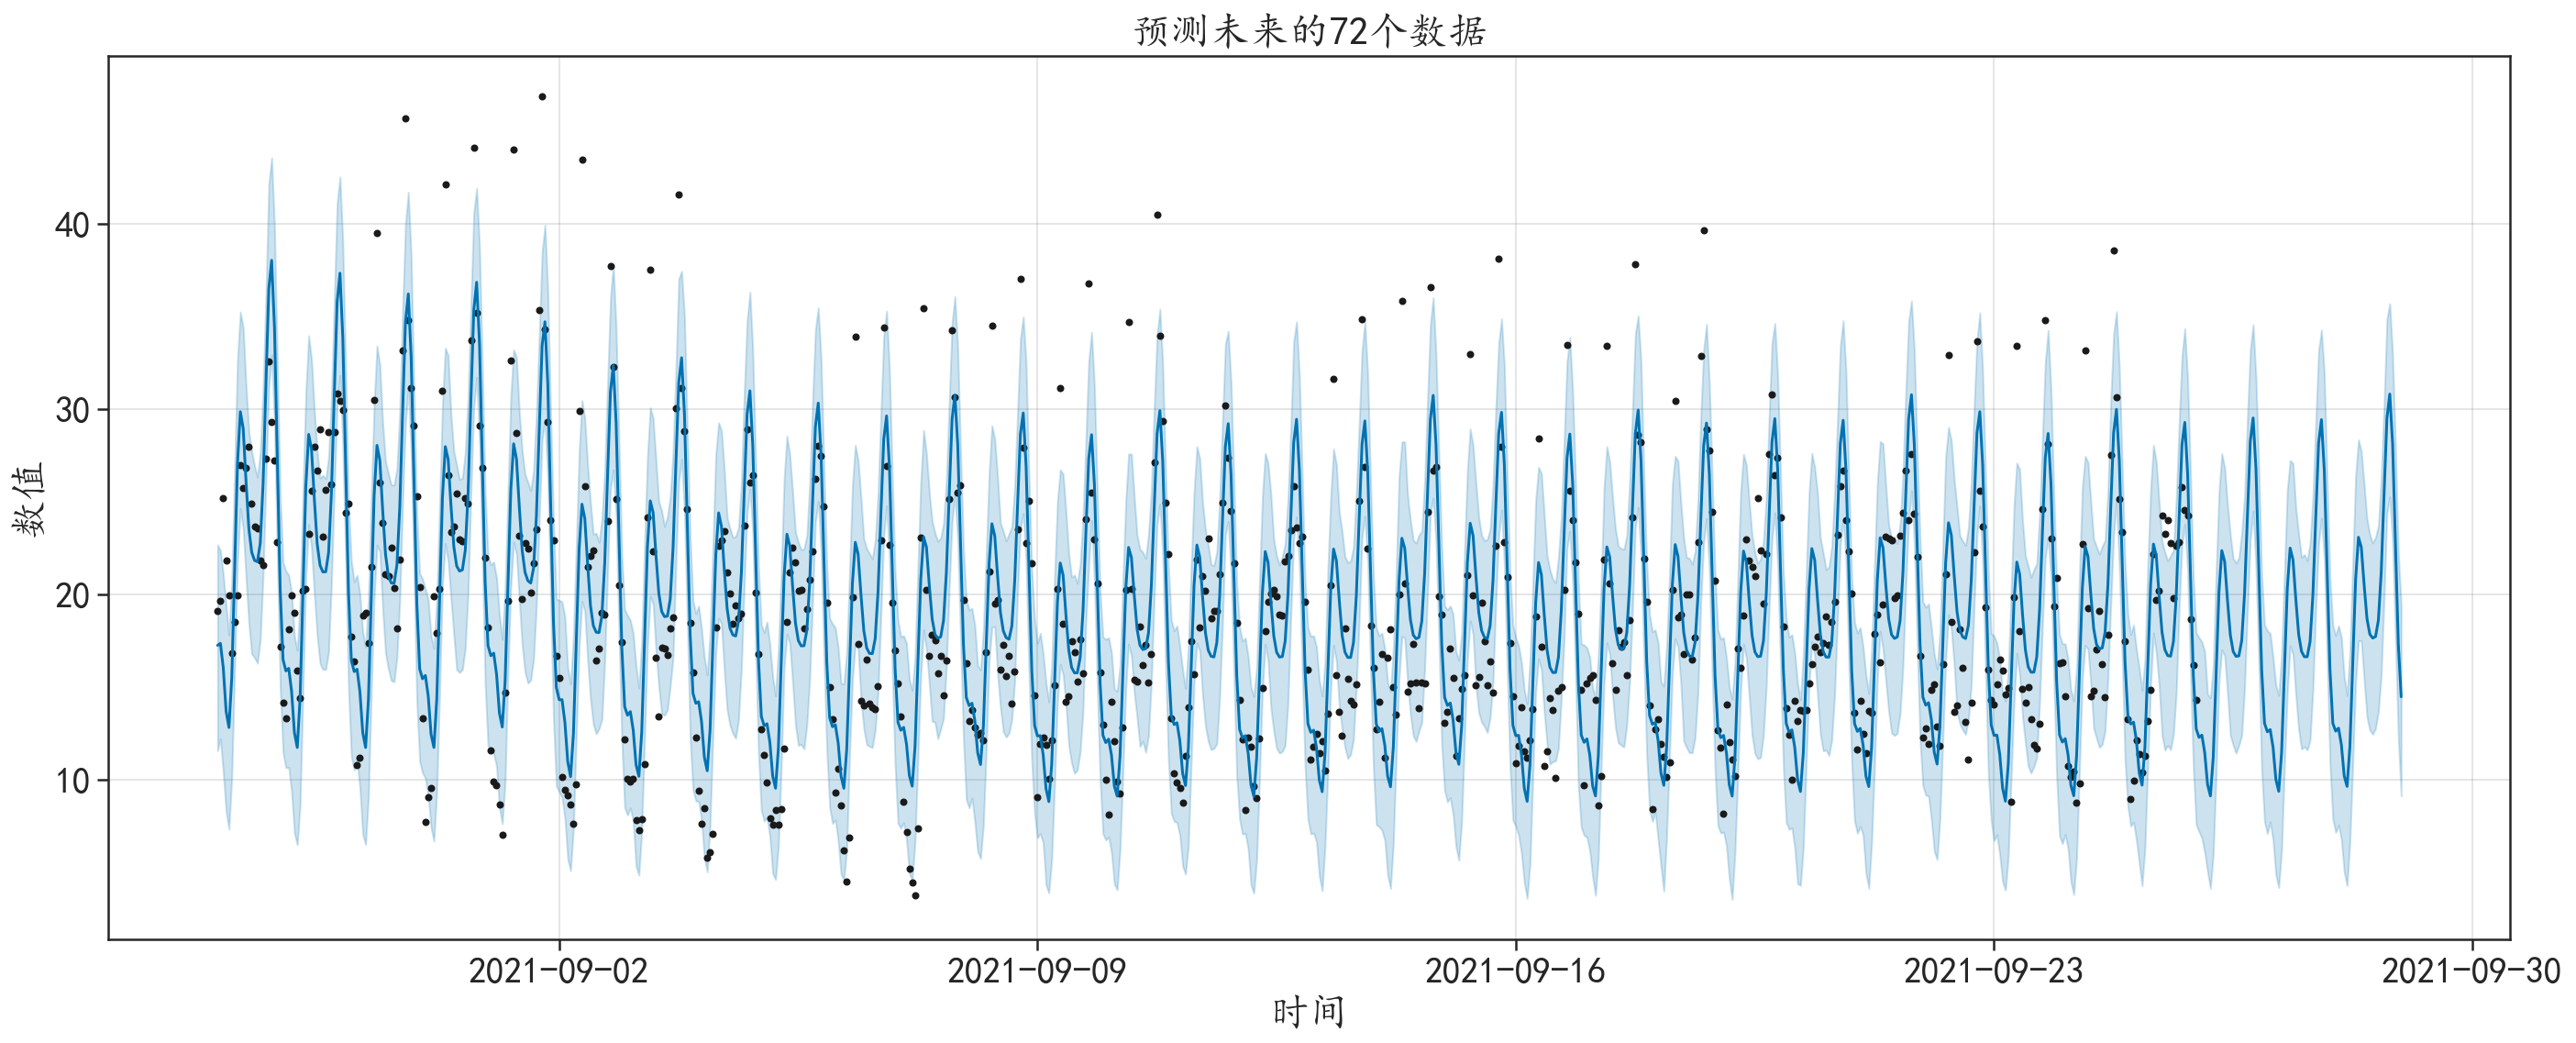

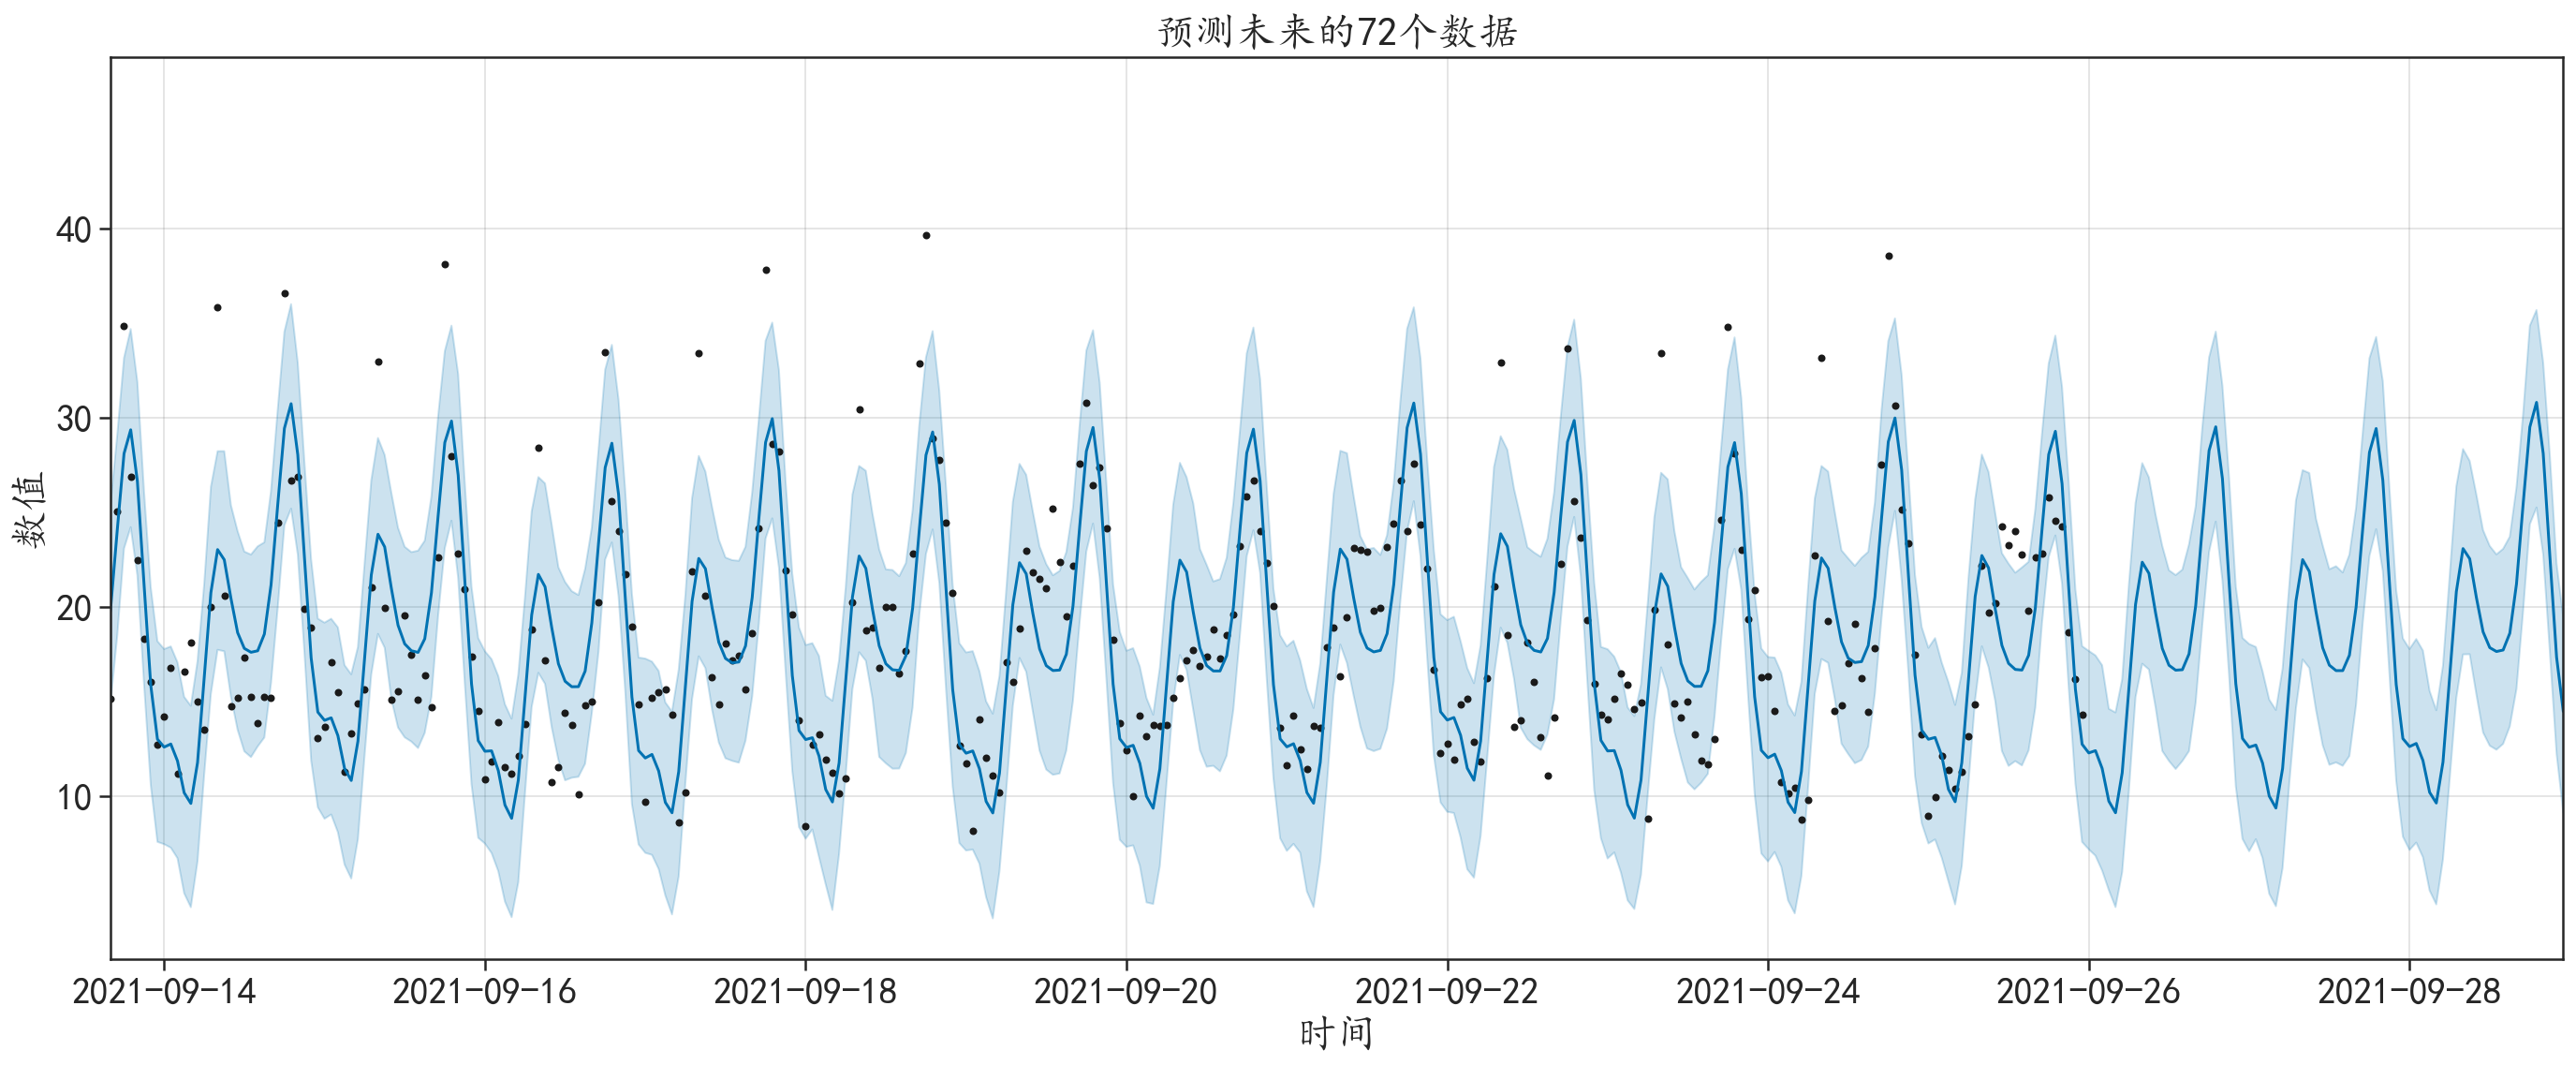

In [24]:
## 可视化预测结果
model.plot(forecast,figsize=(20,8),xlabel = "时间", ylabel = "数值")
plt.title("预测未来的72个数据")
plt.show()
## 可视化预测结果,可视化更多的细节
model.plot(forecast,figsize=(20,8),xlabel = "时间", ylabel = "数值")
plt.xlim([forecast.ds.values[400],forecast.ds.values[-1]])
plt.title("预测未来的72个数据")
plt.show()

## 从可视化效果上，可以看出预测的结果非常的好，趋势也很符合数据的变化趋势

### 介绍深度学习算法，对时间序列数据进行预测

### NeuralProphet

https://neuralprophet.com/html/index.html

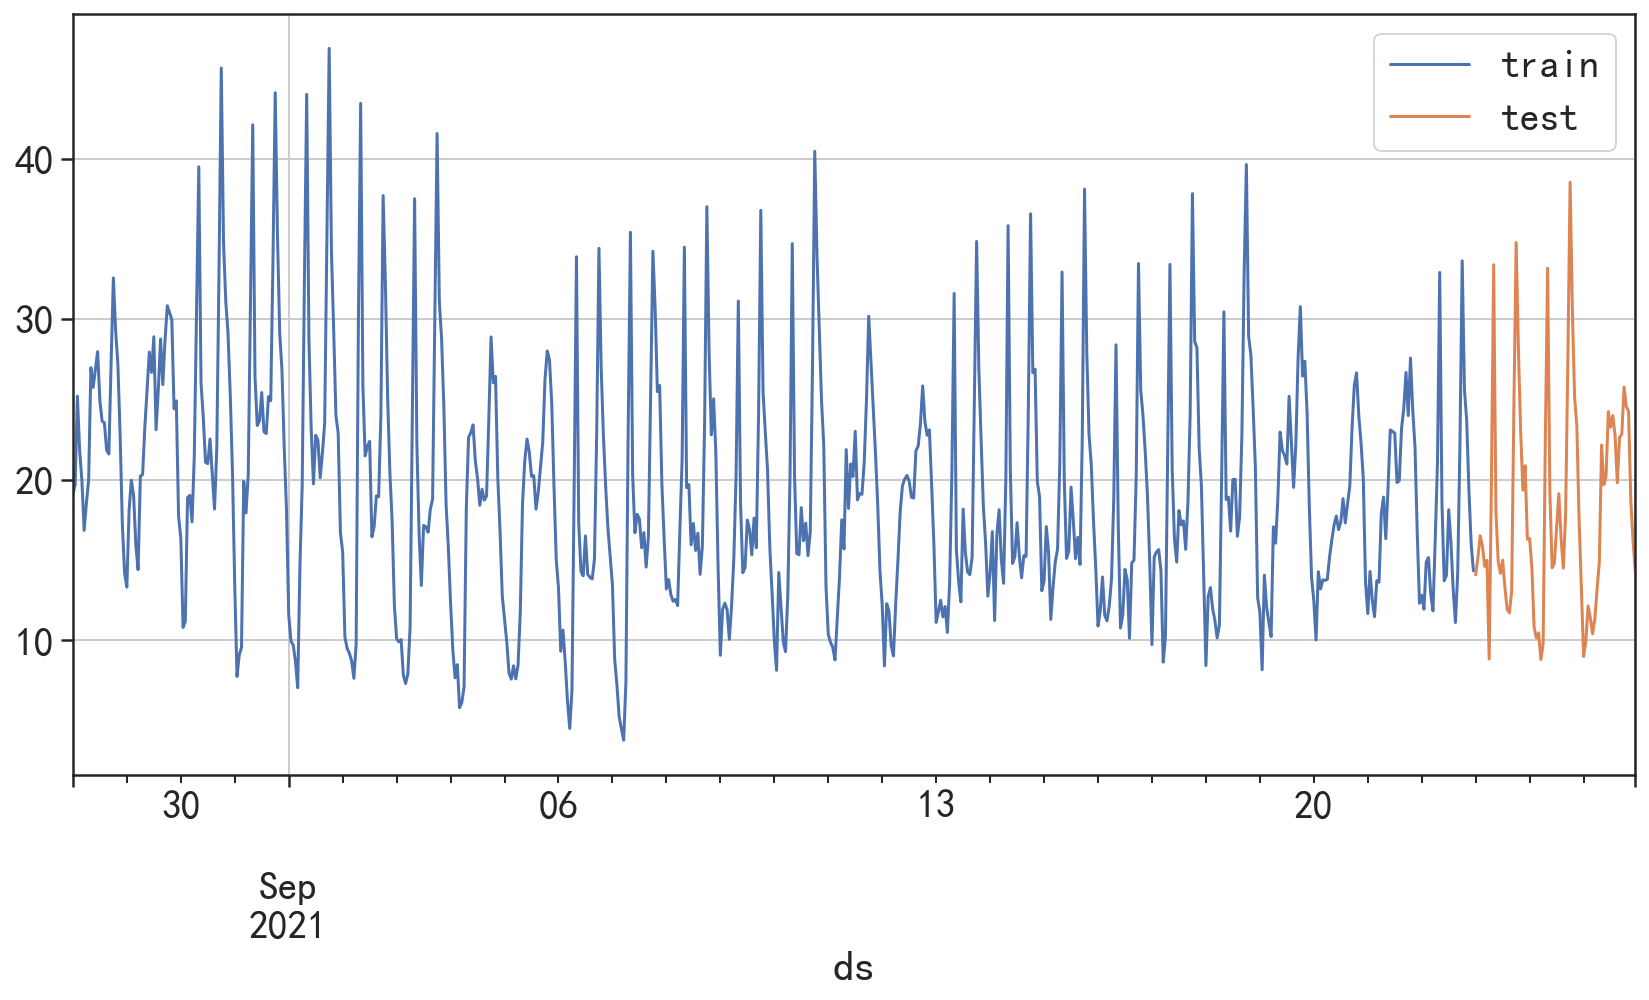

In [25]:
## 使用NeuralProphet算法对时间序列数据进行预测
tspredf =  usenumdf.loc[usenumdf["小区编号"] == 26019015,["时间","number"]]
tspredf.columns = ["ds","y"]
## 对序列进行切分，后面的3天的数据用于测试集
train = pd.DataFrame(tspredf[0:len(tspredf) - 72])
test = pd.DataFrame(tspredf[len(tspredf) - 72:])
## 可视化切分后的数据
fig = plt.figure()
ax = fig.add_subplot(111)
train.plot(figsize=(14,7), x = "ds",y = "y",label = "train",ax = ax)
test.plot(x = "ds",y = "y",label = "test",ax = ax)
plt.legend()
plt.grid()
plt.show()

In [26]:
## 定义一个NeuralProphet模型
model = NeuralProphet(growth = "off",yearly_seasonality='auto',weekly_seasonality='auto',
                      daily_seasonality='auto',seasonality_mode='additive',num_hidden_layers = 3,
                      d_hidden = 10,loss_func = "MAE",learning_rate = 0.01)
metrics = model.fit(train, freq="H")  ## 使用定义好的模型对训练数据进行训练

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 203
INFO:NP.config:Auto-set epochs to 203
Epoch[203/203]: 100%|█| 203/203 [00:09<00:00, 22.50it/s, L1Loss=0.105, MAE=3.13,


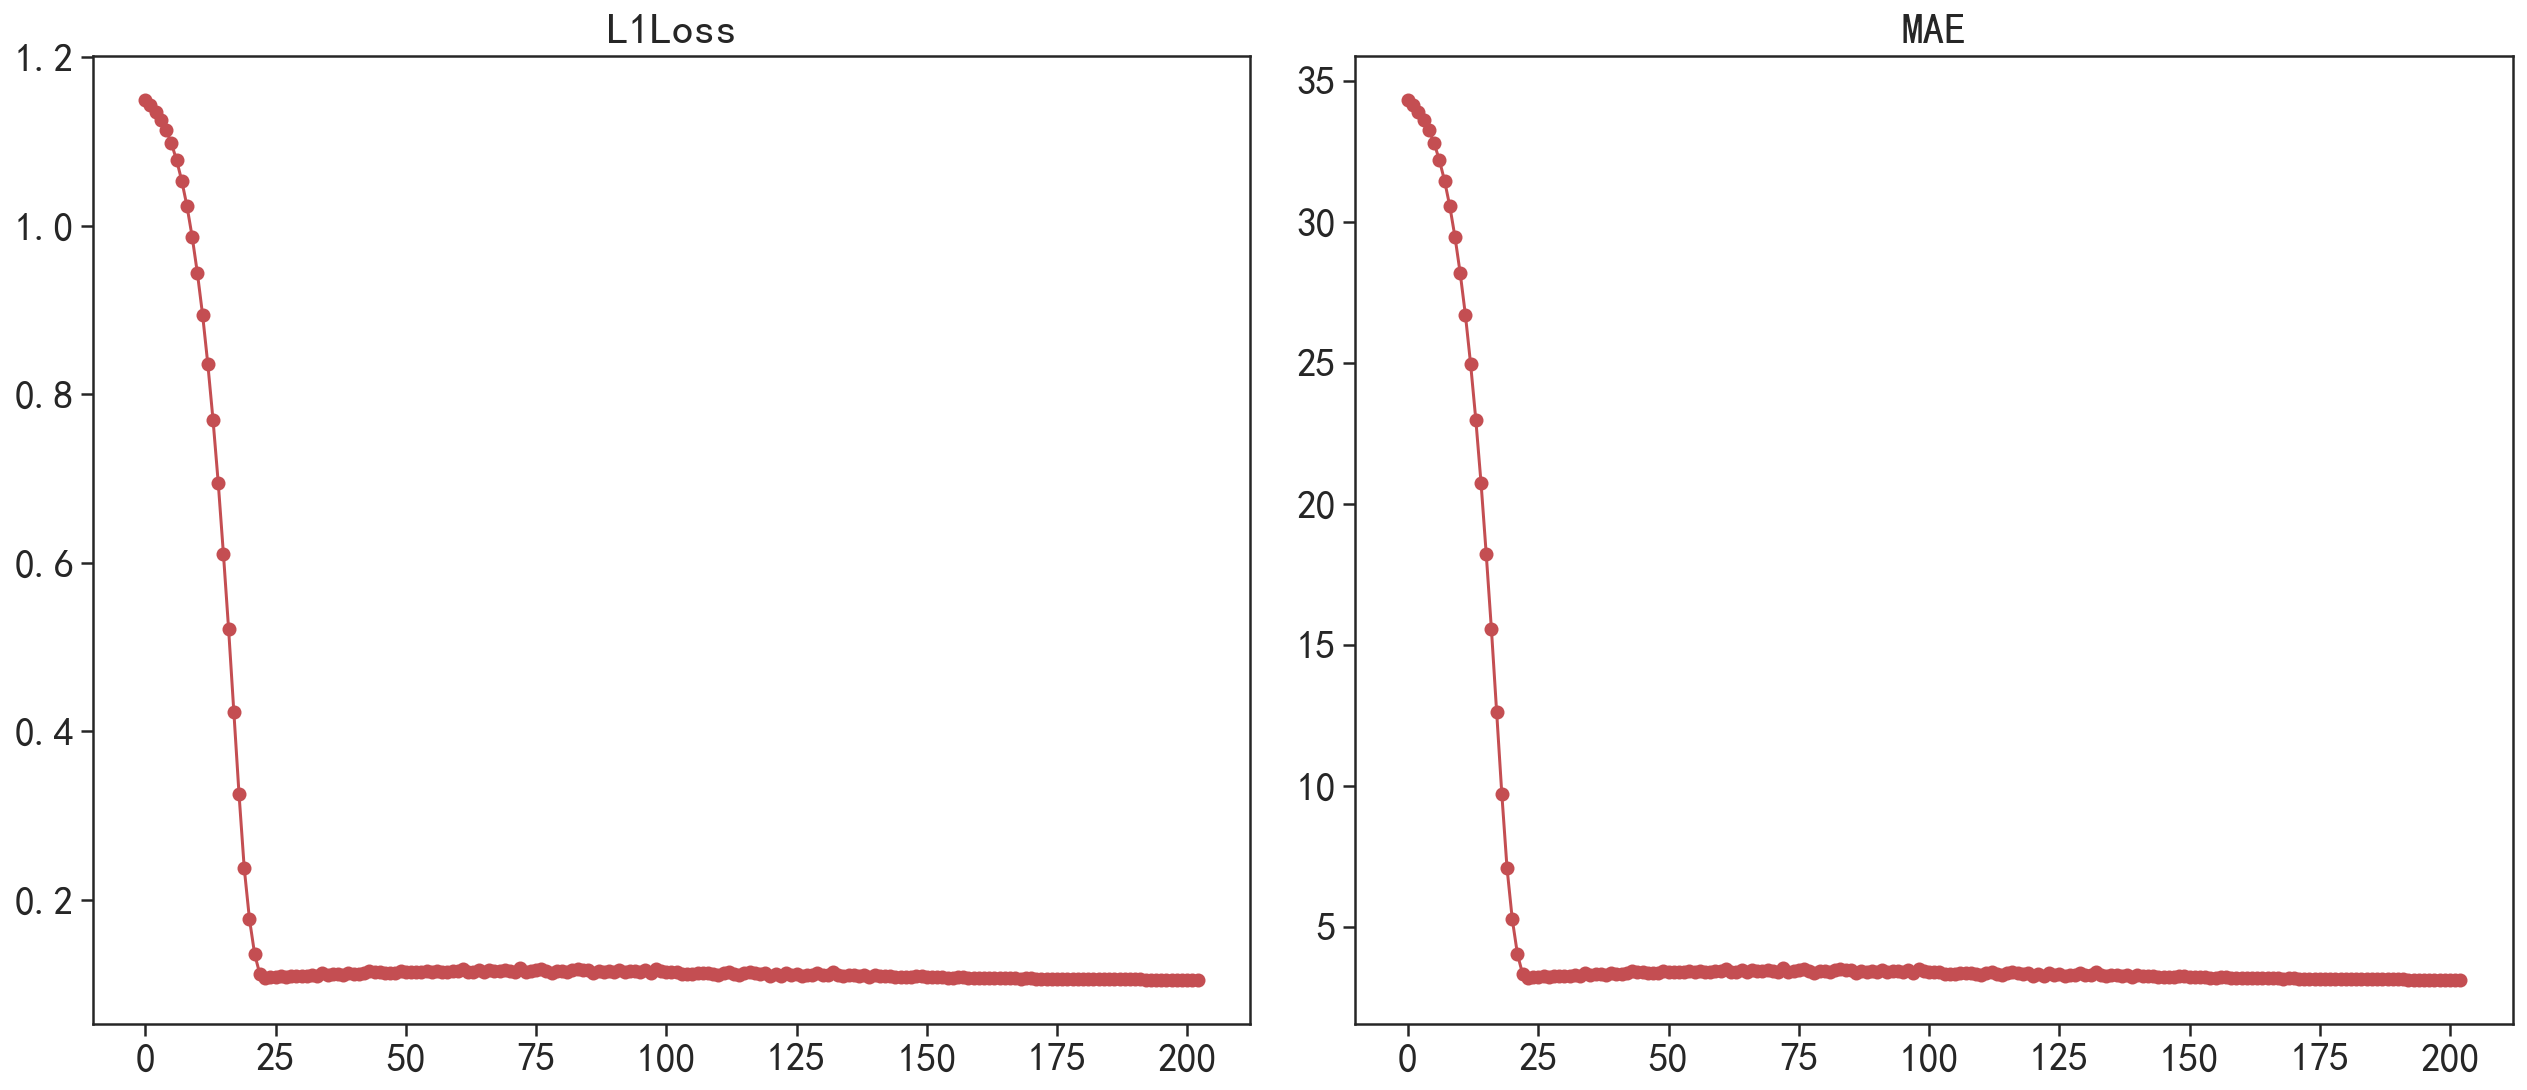

In [27]:
metrics
## 可视化训练过程中损失函数和绝对值误差的变化情况
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(metrics.L1Loss,"r-o")
plt.title("L1Loss")
plt.subplot(1,2,2)
plt.plot(metrics.MAE,"r-o")
plt.title("MAE")
plt.tight_layout()
plt.show()

In [28]:
## 预测未来的3天数据
future = model.make_future_dataframe(train, periods=72)
forecast = model.predict(future)
print("在测试集上绝对值预测误差为:",mean_absolute_error(test.y,forecast.yhat1))
forecast

在测试集上绝对值预测误差为: 3.0073590713924836


ds     y      yhat1 residual1      trend  season_weekly  \
0  2021-09-23 00:00:00  None  10.942549      None  18.459896      -0.675242   
1  2021-09-23 01:00:00  None   9.858335      None  18.459896      -0.807100   
2  2021-09-23 02:00:00  None  10.831161      None  18.459896      -0.934461   
3  2021-09-23 03:00:00  None  11.264444      None  18.459896      -1.056360   
4  2021-09-23 04:00:00  None   9.971205      None  18.459896      -1.171893   
..                 ...   ...        ...       ...        ...            ...   
67 2021-09-25 19:00:00  None  29.769152      None  18.459896       0.626851   
68 2021-09-25 20:00:00  None  26.535439      None  18.459896       0.673232   
69 2021-09-25 21:00:00  None  22.879848      None  18.459896       0.720701   
70 2021-09-25 22:00:00  None  19.419138      None  18.459896       0.768906   
71 2021-09-25 23:00:00  None  15.678970      None  18.459896       0.817445   

    season_daily  
0      -6.842106  
1      -7.794461  
2      -6.694274  
3      -6.139092  
4      -7.316799  
..           ...  
67     10.682405  
68      7.402312  
69      3.699251  
70      0.190335  
71     -3.598370  

[72 rows x 7 columns]

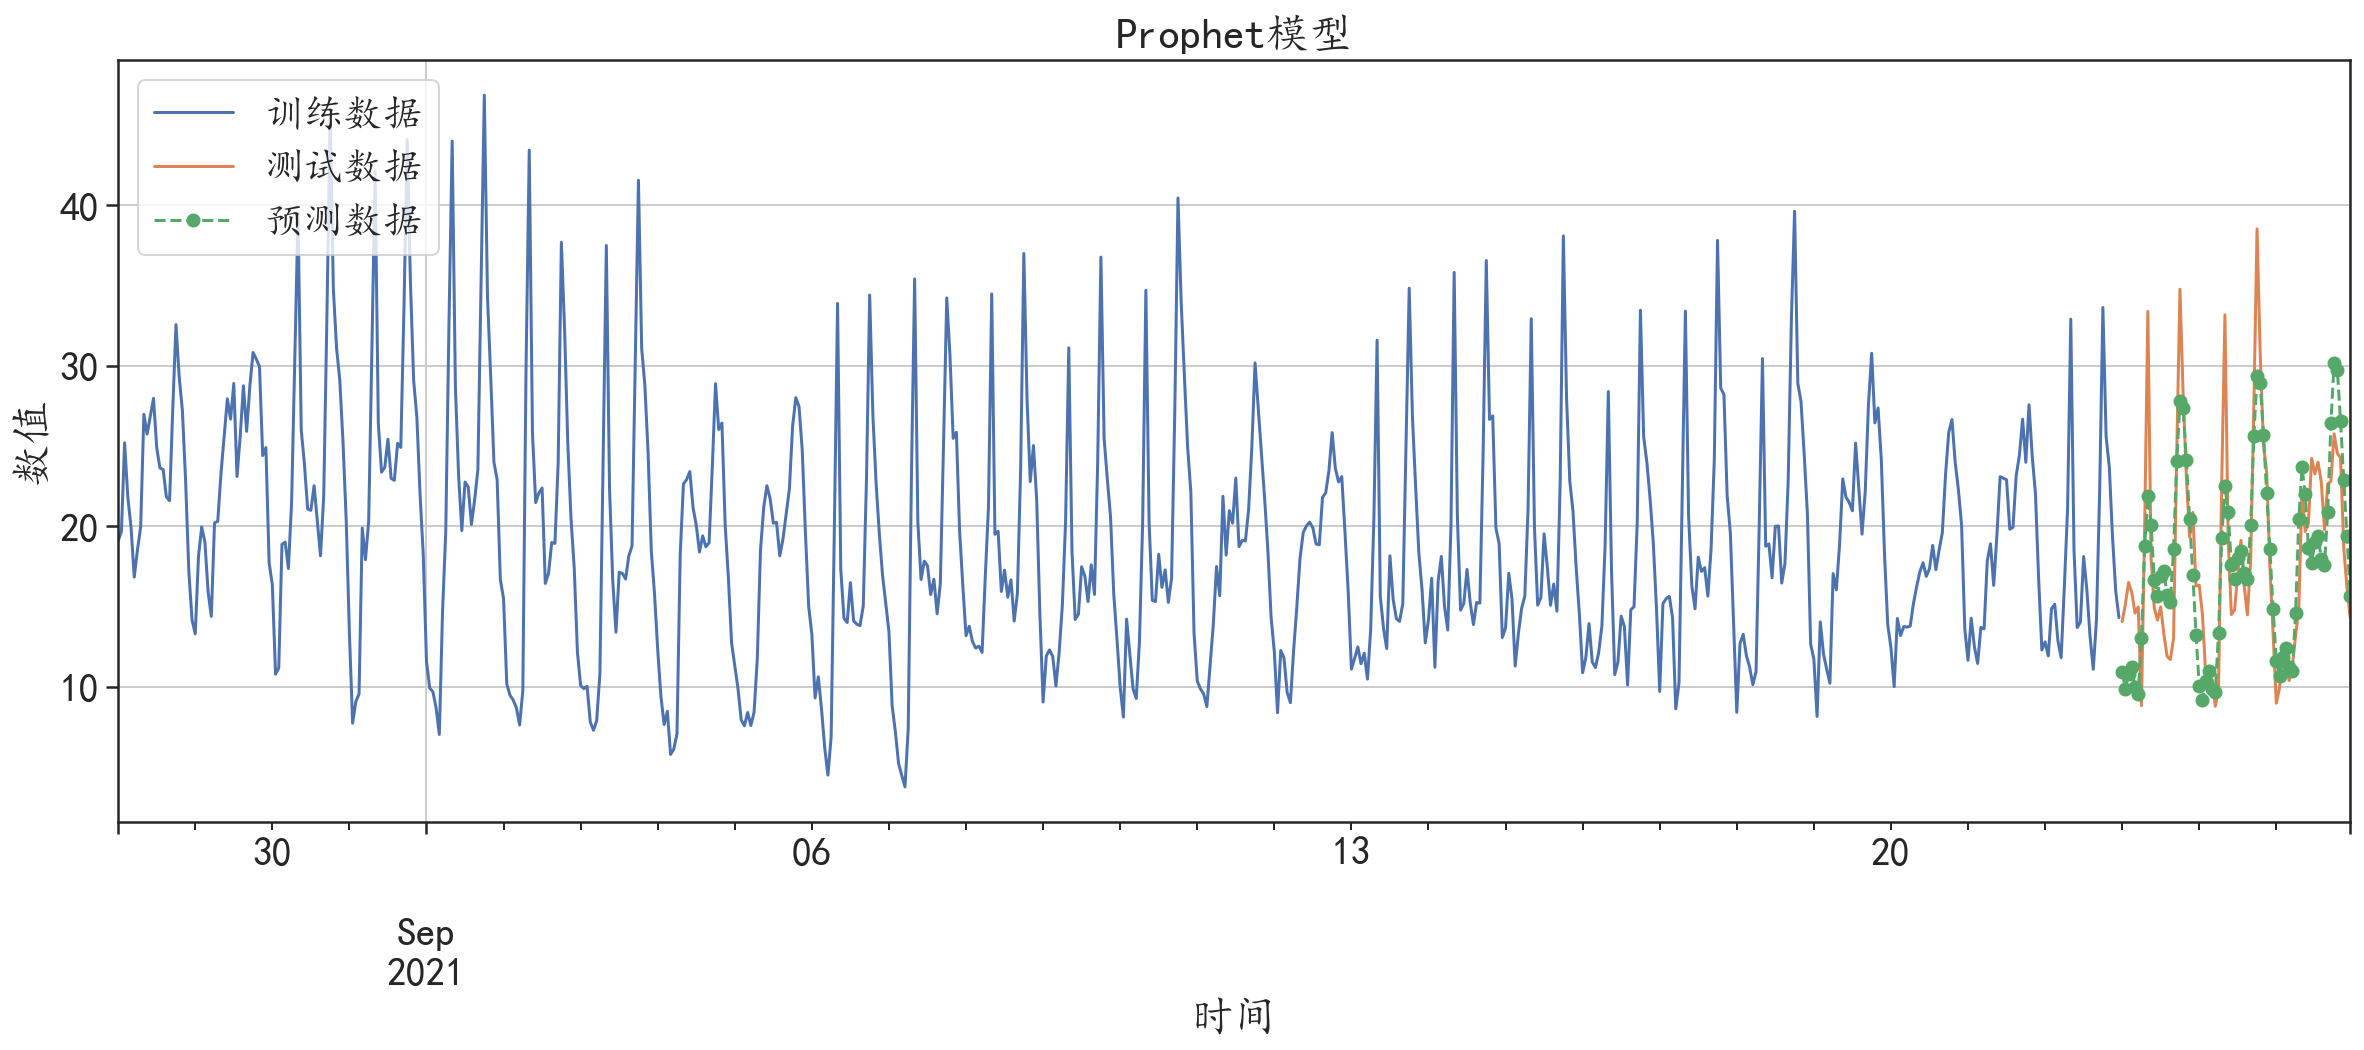

In [29]:

## 可视化原始数据和预测数据进行对比
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
train.plot(x = "ds",y = "y",label="训练数据",ax = ax)
test.plot(x = "ds",y = "y",label="测试数据",ax = ax)
forecast.plot(x = "ds",y = "yhat1",style = "g--o",label="预测数据",ax = ax)
plt.grid()
plt.xlabel("时间")
plt.ylabel("数值")
plt.title("Prophet模型")
plt.legend(loc=2)
plt.show()

## 预测效果看上去挺好

In [30]:
## 定义一个NeuralProphet模型，调整参数
model = NeuralProphet(growth = "off",yearly_seasonality=False,weekly_seasonality="auto",
                      daily_seasonality=24,seasonality_mode="additive",num_hidden_layers = 5,
                      d_hidden = 50,loss_func = "MAE")
metrics = model.fit(train, freq="H")  ## 使用定义好的模型对训练数据进行训练
## 预测未来的3天数据
future = model.make_future_dataframe(train, periods=72)
forecast = model.predict(future)
print("在测试集上绝对值预测误差为:",mean_absolute_error(test.y,forecast.yhat1))

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 203
INFO:NP.config:Auto-set epochs to 203


  0%|          | 0/240 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.86E-02, min: 3.27E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.86E-02, min: 3.27E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 1.73E-01
INFO:NP.utils_torch:learning rate range test selected lr: 1.73E-01
Epoch[203/203]: 100%|█| 203/203 [00:09<00:00, 22.04it/s, L1Loss=0.0973, MAE=2.91


在测试集上绝对值预测误差为: 2.7916911795722115


In [31]:
## 使用NeuralProphet，对所有数据训练，并预测未来的3天
model = NeuralProphet(growth = "off",yearly_seasonality=False,weekly_seasonality="auto",
                      daily_seasonality=24,seasonality_mode="additive",num_hidden_layers = 5,
                      d_hidden = 50,loss_func = "MAE")
metrics = model.fit(tspredf, freq="H")  ## 使用定义好的模型对训练数据进行训练
future = model.make_future_dataframe(tspredf, periods=72)
forecast = model.predict(future)
# forecasts_plot = model.plot(forecast)

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 198
INFO:NP.config:Auto-set epochs to 198


  0%|          | 0/242 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.66E-02, min: 2.89E-01
INFO:NP.utils_torch:lr-range-test results: steep: 8.66E-02, min: 2.89E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 1.93E-01
INFO:NP.utils_torch:learning rate range test selected lr: 1.93E-01
Epoch[198/198]: 100%|█| 198/198 [00:09<00:00, 20.32it/s, L1Loss=0.0973, MAE=2.89


In [32]:
forecast

ds     y      yhat1 residual1      trend  season_weekly  \
0  2021-09-26 00:00:00  None  12.388357      None  10.253498       0.608646   
1  2021-09-26 01:00:00  None  11.549248      None  10.253498       0.656379   
2  2021-09-26 02:00:00  None  12.781055      None  10.253498       0.702803   
3  2021-09-26 03:00:00  None  12.010408      None  10.253498       0.747392   
4  2021-09-26 04:00:00  None  12.302242      None  10.253498       0.789614   
..                 ...   ...        ...       ...        ...            ...   
67 2021-09-28 19:00:00  None  29.016193      None  10.253498       1.111861   
68 2021-09-28 20:00:00  None  26.688469      None  10.253498       1.168128   
69 2021-09-28 21:00:00  None  23.678247      None  10.253498       1.216243   
70 2021-09-28 22:00:00  None  19.974792      None  10.253498       1.255575   
71 2021-09-28 23:00:00  None  15.628031      None  10.253498       1.285575   

    season_daily  
0       1.526213  
1       0.639371  
2       1.824755  
3       1.009519  
4       1.259130  
..           ...  
67     17.650835  
68     15.266844  
69     12.208505  
70      8.465717  
71      4.088958  

[72 rows x 7 columns]

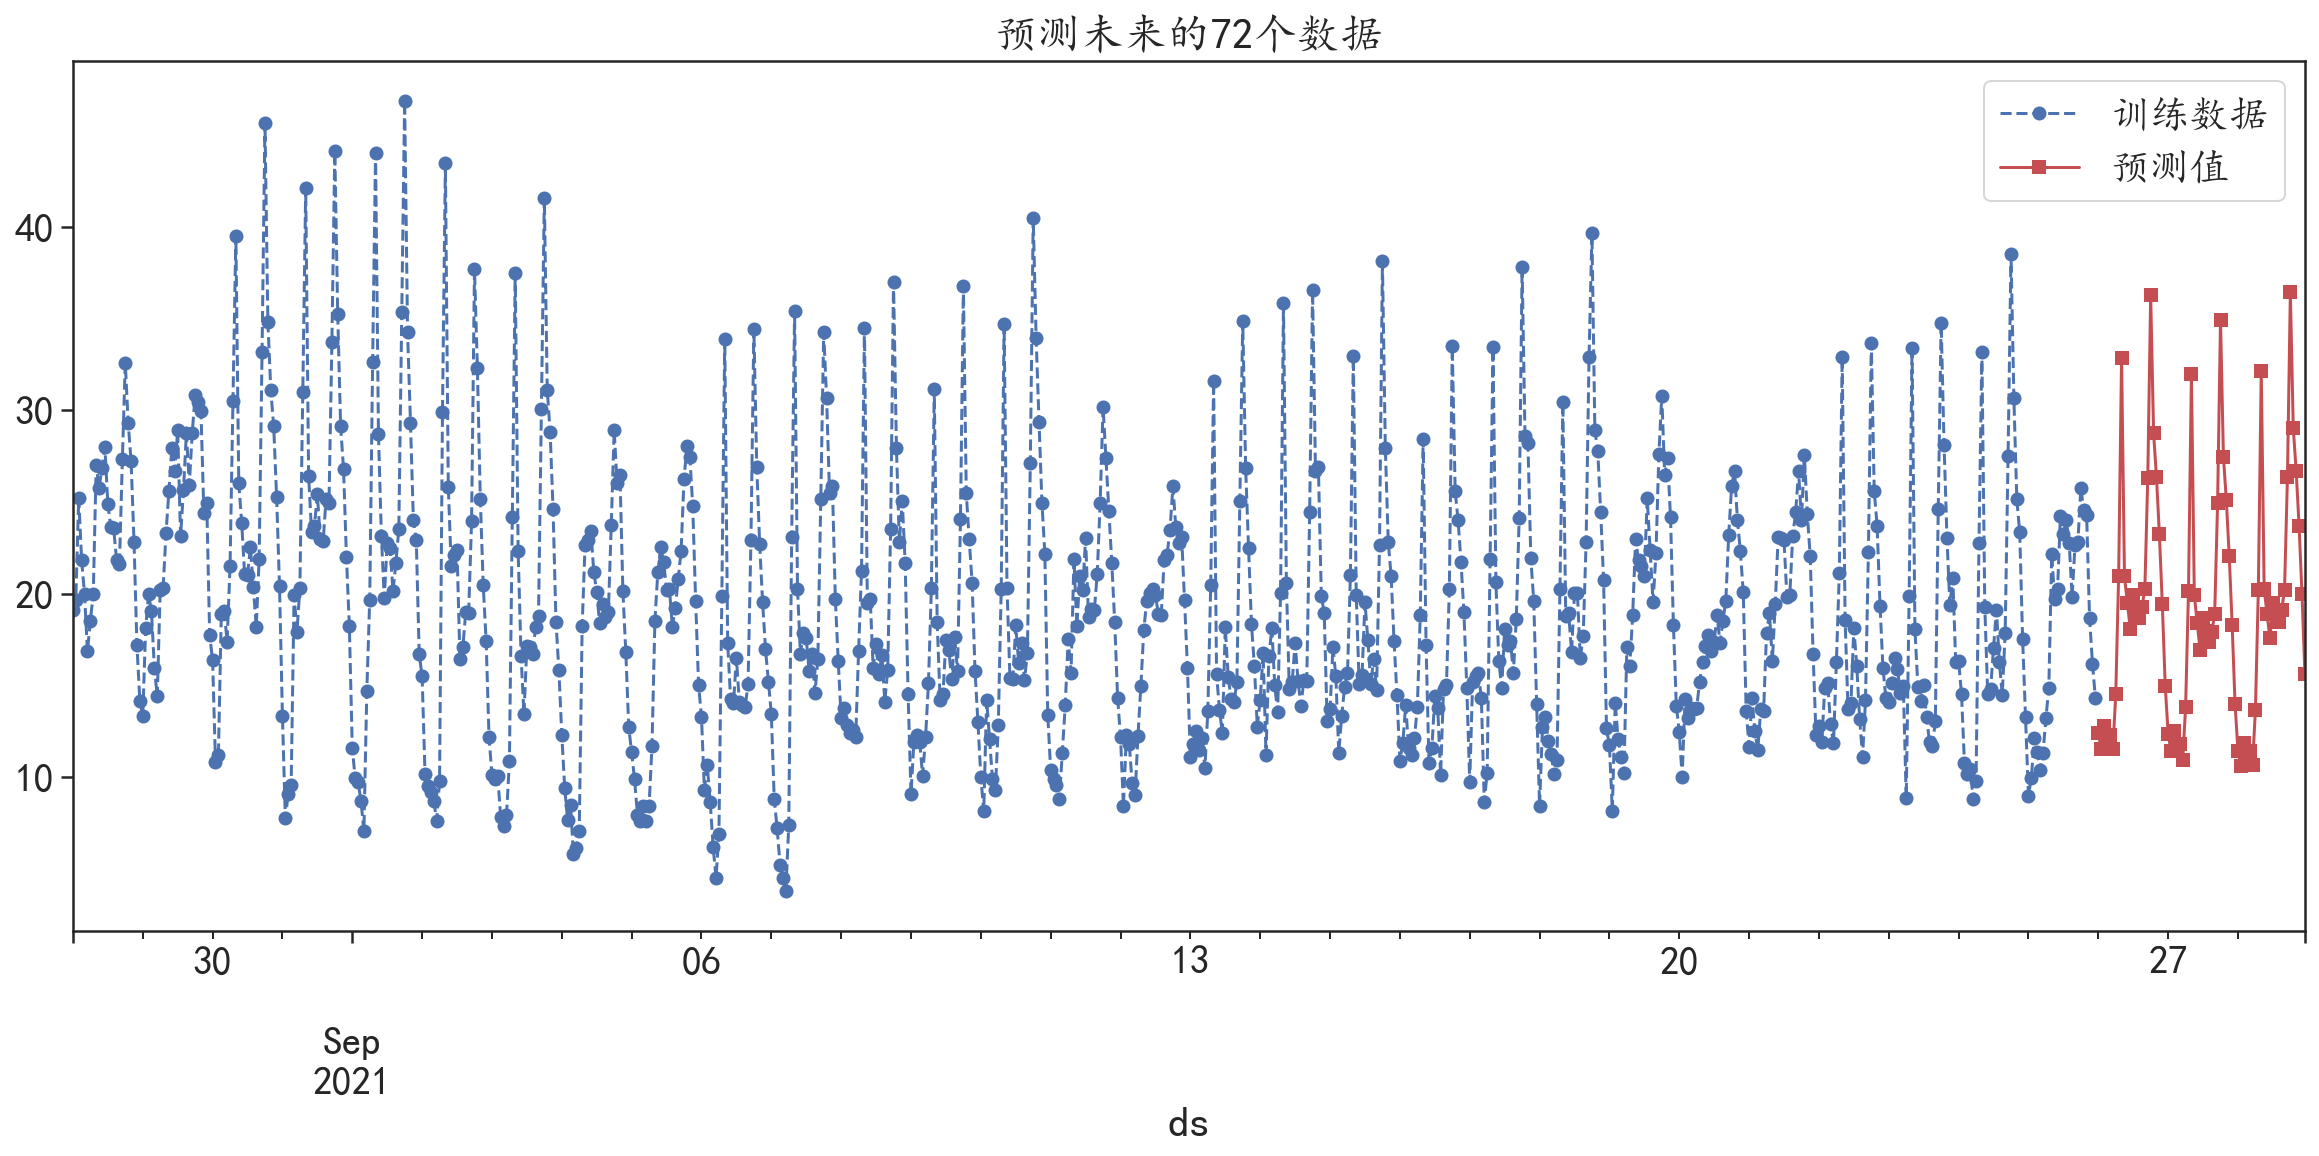

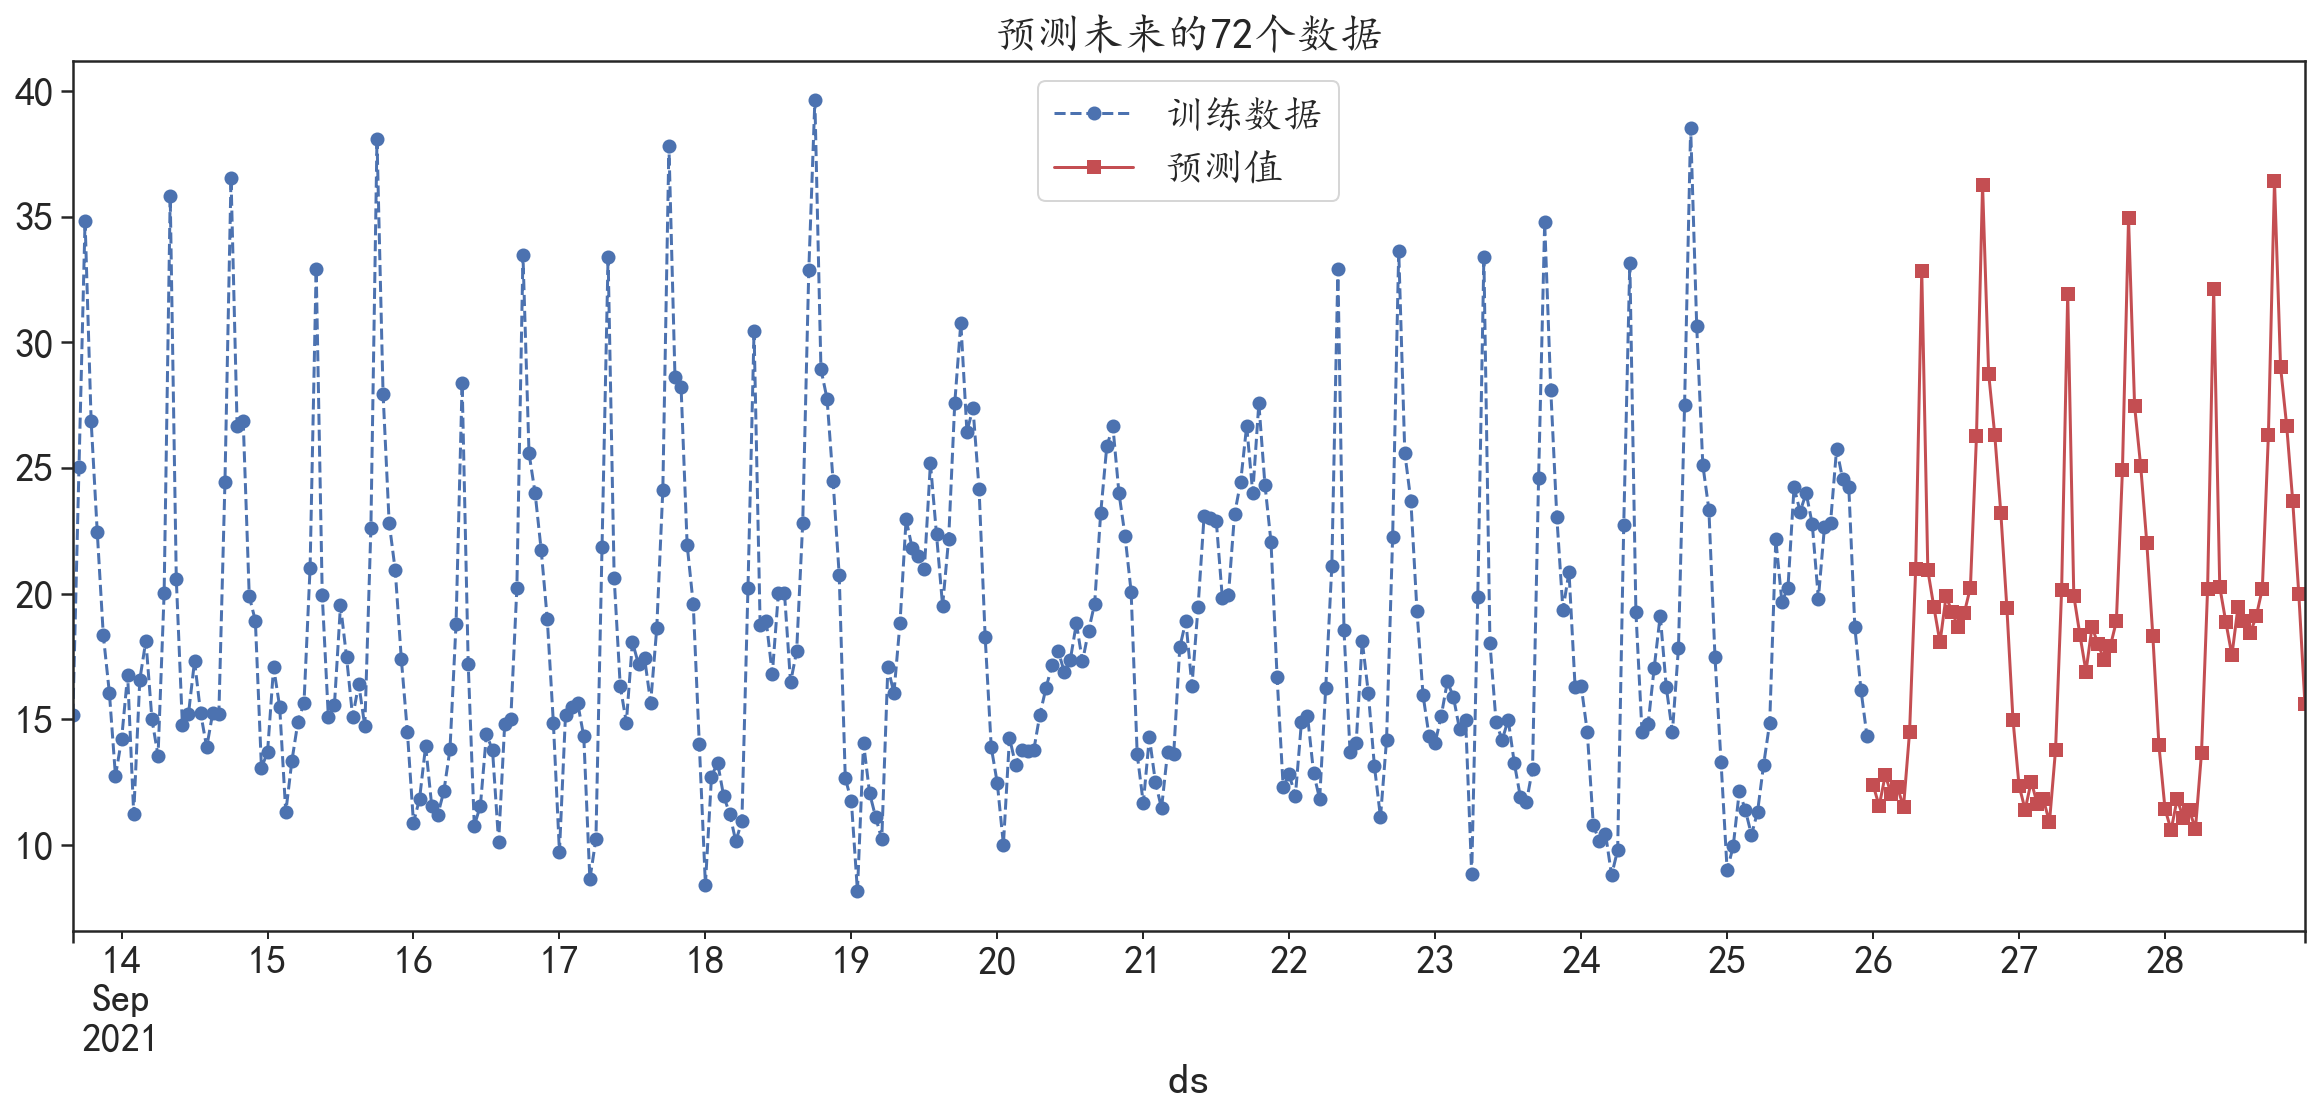

In [33]:
## 可视化模型的预测效果
fig,ax = plt.subplots()
tspredf.plot(x= "ds",y = "y",style = "b--o",figsize=(20,8),ax = ax,label = "训练数据")
forecast.plot(x= "ds",y = "yhat1",style = "r-s",ax = ax,label = "预测值")
plt.title("预测未来的72个数据")
plt.show()
fig,ax = plt.subplots()
tspredf[400:].plot(x= "ds",y = "y",style = "b--o",figsize=(20,8),ax = ax,label = "训练数据")
forecast.plot(x= "ds",y = "yhat1",style = "r-s",ax = ax,label = "预测值")
plt.title("预测未来的72个数据")
plt.show()

### 使用darts包中的一些模型进行预测时间序列

https://unit8co.github.io/darts/README.html

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from darts import TimeSeries
from darts.models import RNNModel, TCNModel
from darts.metrics import mae
from darts.utils.likelihood_models import GaussianLikelihood

In [35]:
## 数据准备
tspredf =  usenumdf.loc[usenumdf["小区编号"] == 26019015,["时间","number"]]
tspredf.columns = ["ds","y"]
## 将表格转化为序列
tspredf2 = TimeSeries.from_dataframe(tspredf,time_col ="ds",value_cols="y")
## 数据切分为训练集和测试集
train, val = tspredf2.split_after(pd.Timestamp("2021-09-22 23:00:00"))
print(len(train))
print(len(val))

624
72


In [36]:
## 建立一个LSTM时间序列预测模型
my_model = RNNModel(
    model="LSTM",
    hidden_dim=50,
    dropout=0,
    batch_size=48,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    model_name="my_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=48,
    input_chunk_length=24,
    force_reset=True
)
## 使用数据进行训练
my_model.fit(train,val_series=val,verbose=True)

[2021-10-30 19:24:03,152] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 576 samples.
[2021-10-30 19:24:03,152] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 576 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 576 samples.
[2021-10-30 19:24:03,156] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-30 19:24:03,156] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

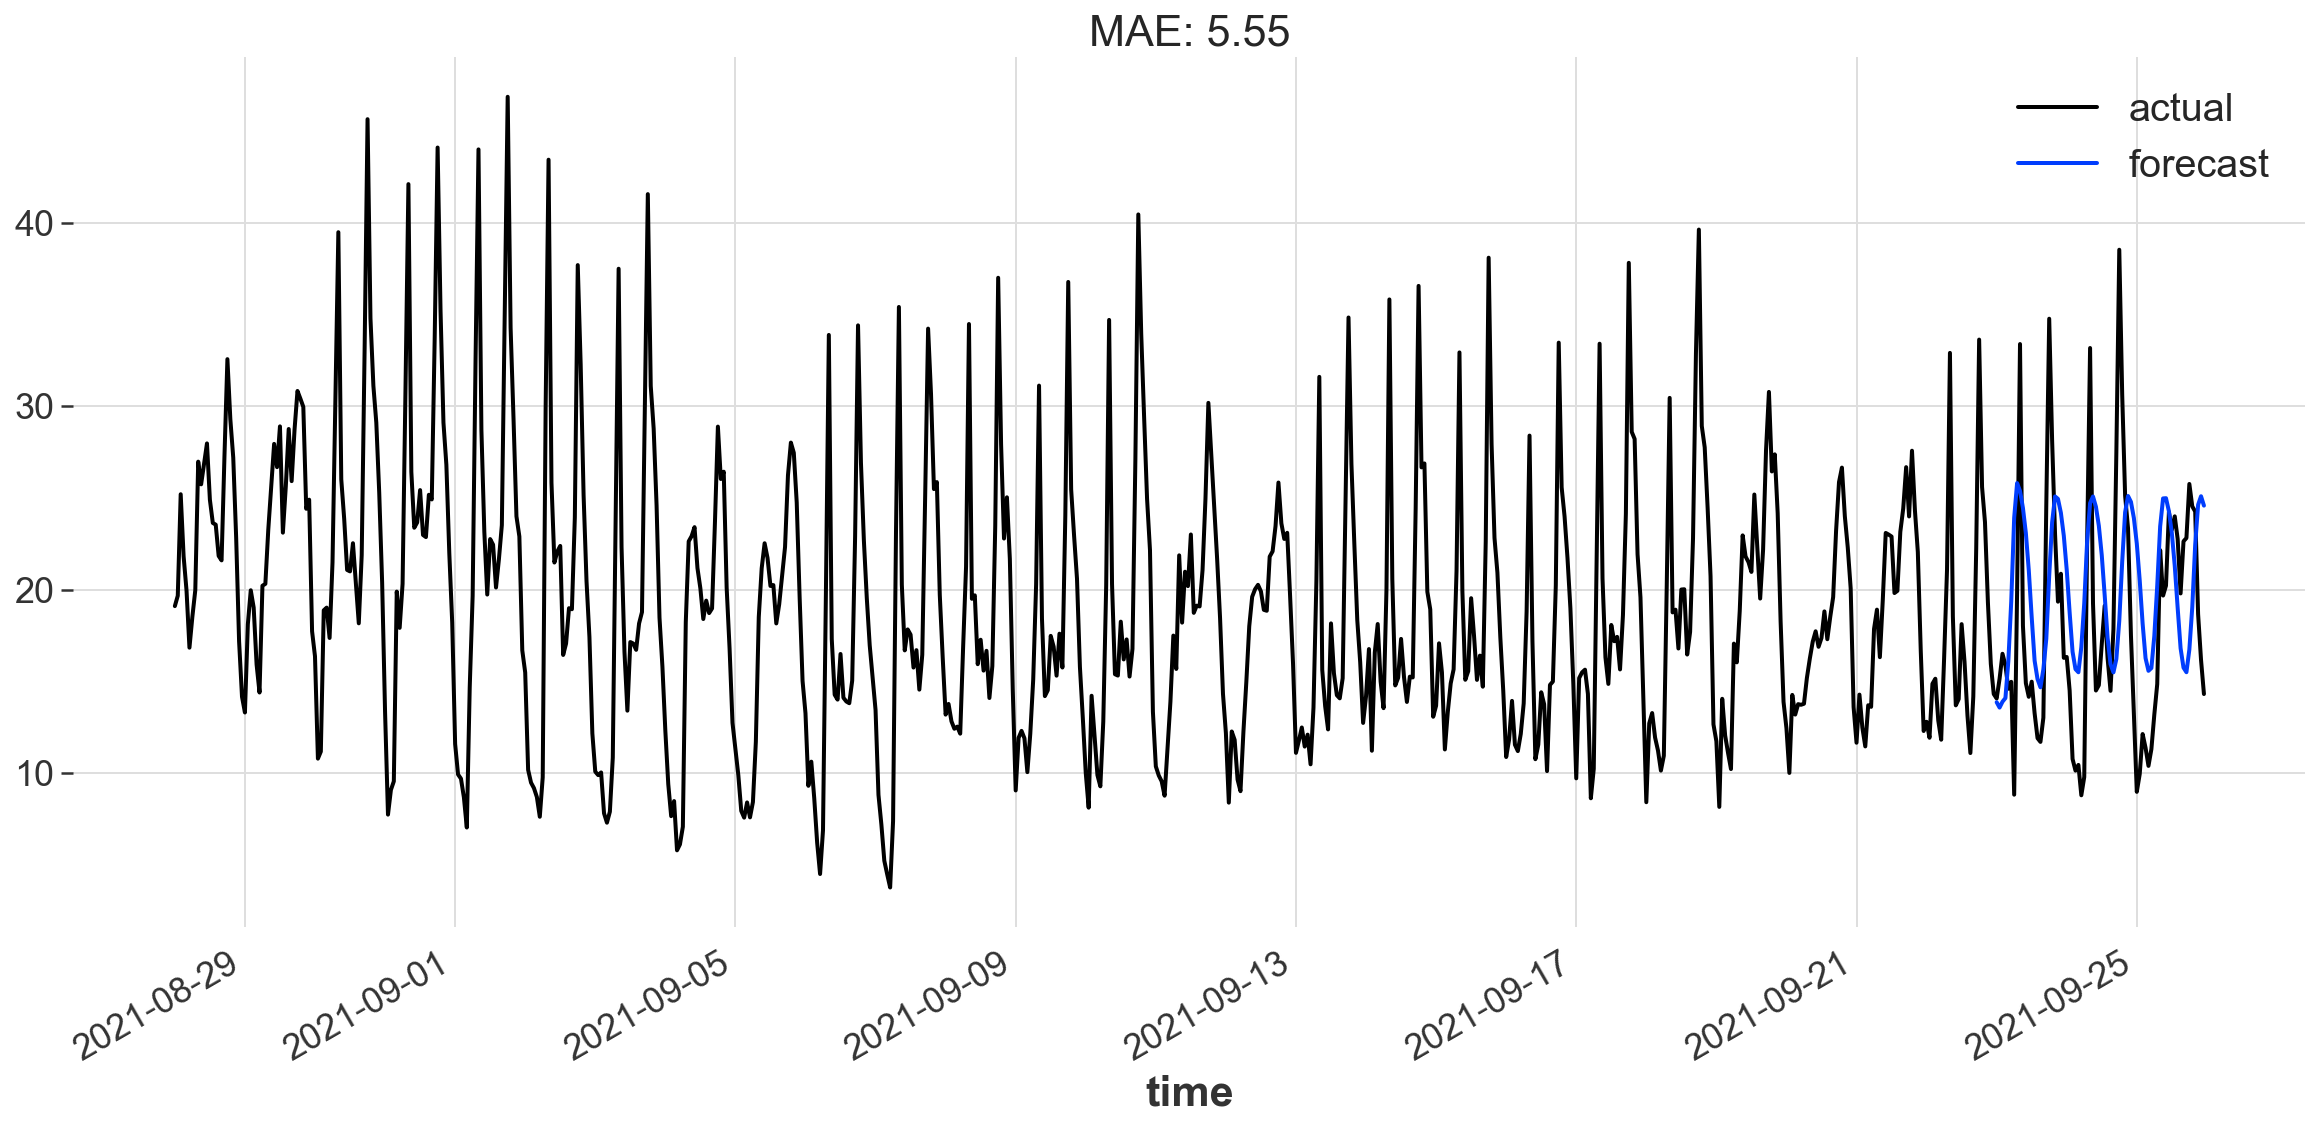

In [37]:
## 可视化模型的预测预测效果
def eval_model(model):
    pred_series = model.predict(n=72)
    plt.figure(figsize=(20,8))
    tspredf2.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAE: {:.2f}".format(mae(pred_series,val)))
    plt.legend()
    plt.show()
eval_model(my_model)

In [38]:
## 使用全部数据训练模型，并预测未来的数据
my_model.fit(tspredf2,verbose=True)


[2021-10-30 19:24:47,271] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 648 samples.
[2021-10-30 19:24:47,271] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 648 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 648 samples.


  0%|          | 0/100 [00:00<?, ?it/s]

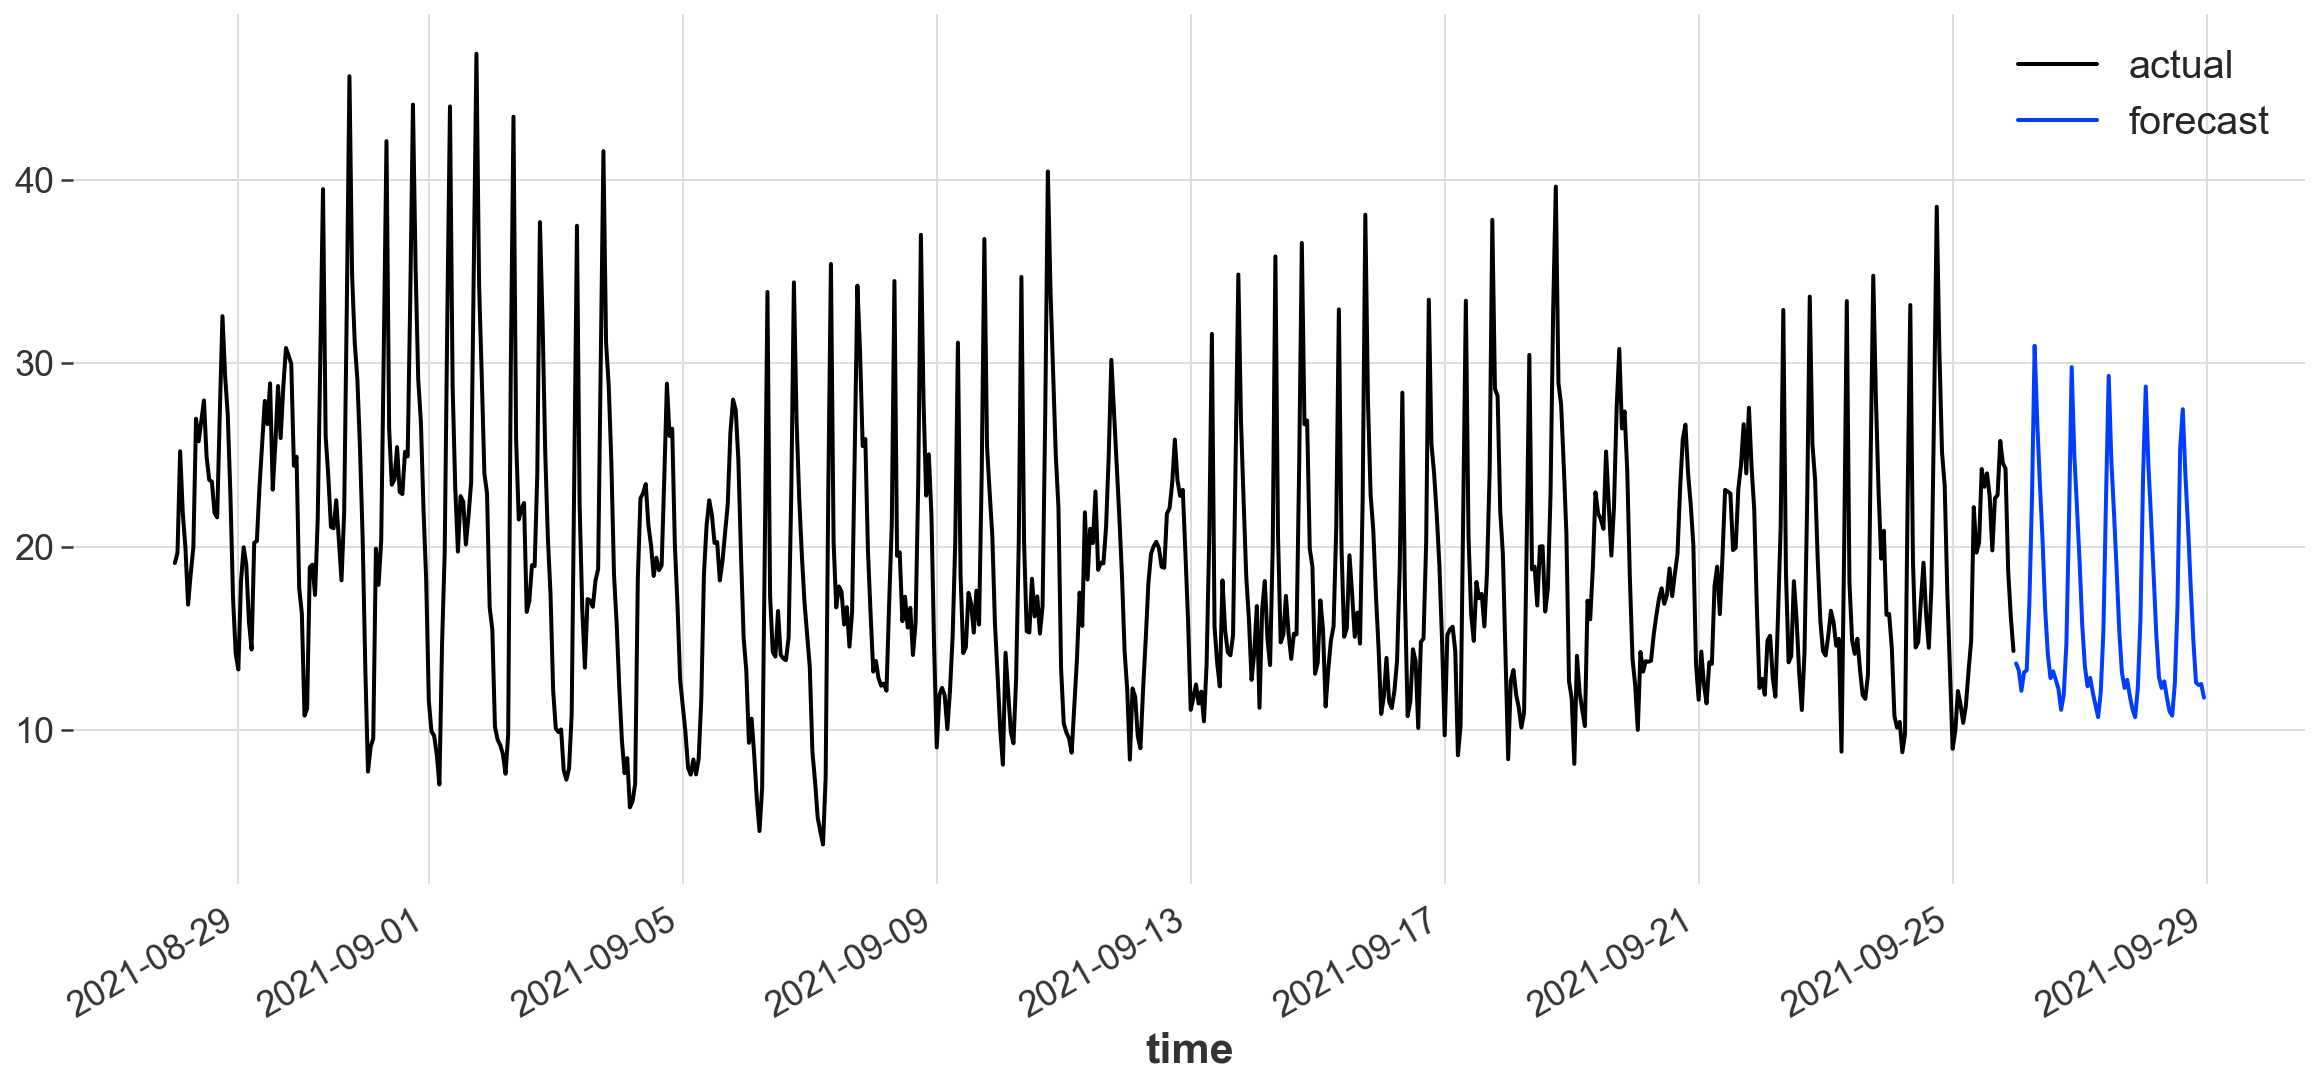

In [39]:
## 可是户对未来的预测效果
pred_series = my_model.predict(n=72)
plt.figure(figsize=(20,8))
tspredf2.plot(label="actual")
pred_series.plot(label="forecast")
plt.legend()
plt.show()

In [40]:
## 更多的时间序列预测算法，可以参考：https://unit8co.github.io/darts/examples.html
## 时间序列异常值检测算法，也可参考：https://adtk.readthedocs.io/en/stable/index.html

In [41]:
## 使用SeasonalAD检测时间序列中的异常值
from adtk.detector import SeasonalAD,GeneralizedESDTestAD
from adtk.data import validate_series,split_train_test
from adtk.visualization import plot

In [42]:
## 数据准备
tspredf =  usenumdf.loc[usenumdf["小区编号"] == 26019015,["时间","number"]]
tspredf.columns = ["ds","y"]
tspredf2 = tspredf.set_index("ds")
tspredf2.head()

y
ds                          
2021-08-28 00:00:00  19.1064
2021-08-28 01:00:00  19.6728
2021-08-28 02:00:00  25.2039
2021-08-28 03:00:00  21.8198
2021-08-28 04:00:00  19.9522

In [43]:
## 检测出异常值
seasonal_ad = SeasonalAD(freq = 24,c=3, side="both")
anomalies = seasonal_ad.fit_detect(tspredf2)
print("异常值数量:",anomalies.y.sum())
anomalies.head()

异常值数量: 5


y
ds                        
2021-08-28 00:00:00  False
2021-08-28 01:00:00  False
2021-08-28 02:00:00   True
2021-08-28 03:00:00  False
2021-08-28 04:00:00  False

[<AxesSubplot:>]

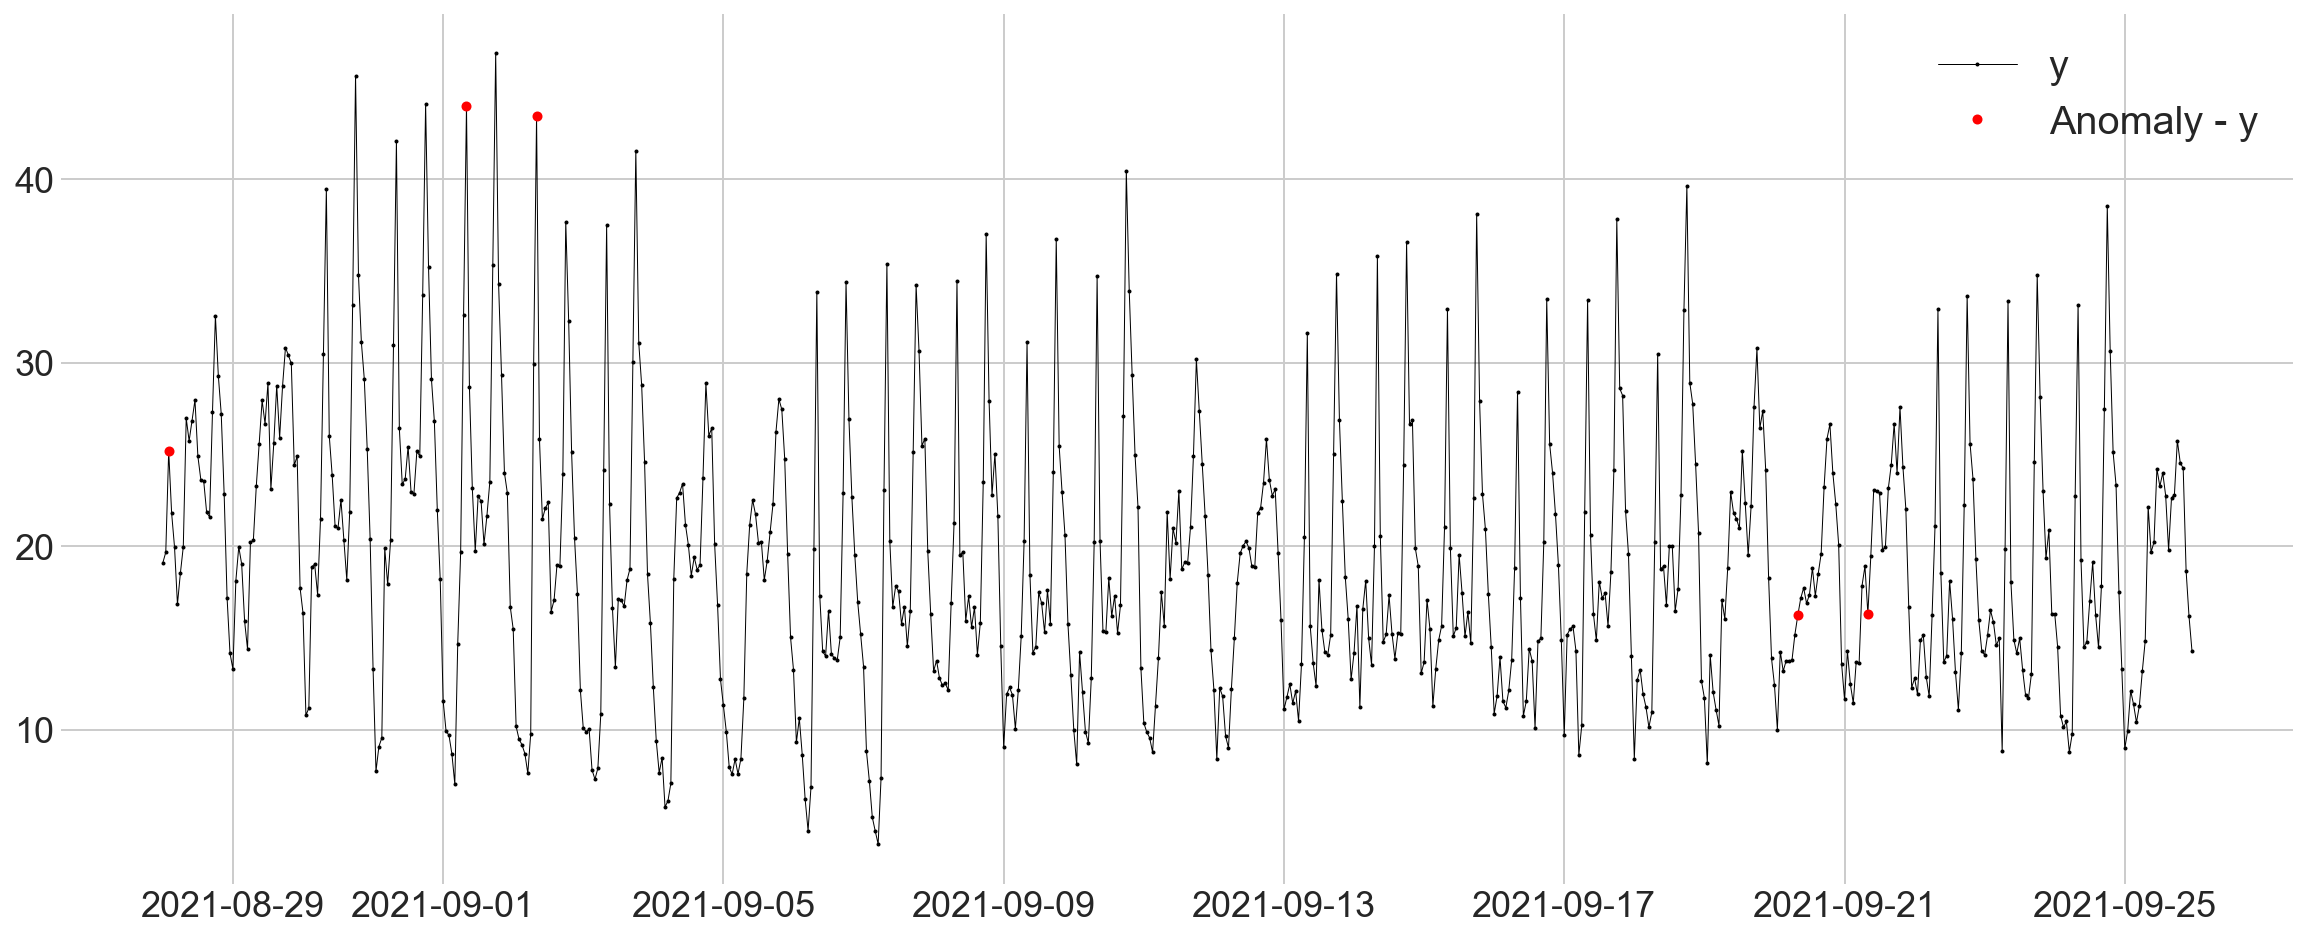

In [44]:
## 可视化出数据汇总异常值的情况
plot(tspredf2, anomaly=anomalies, ts_markersize=2, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=4,figsize=(20,8))

异常值数量: 16


[<AxesSubplot:>]

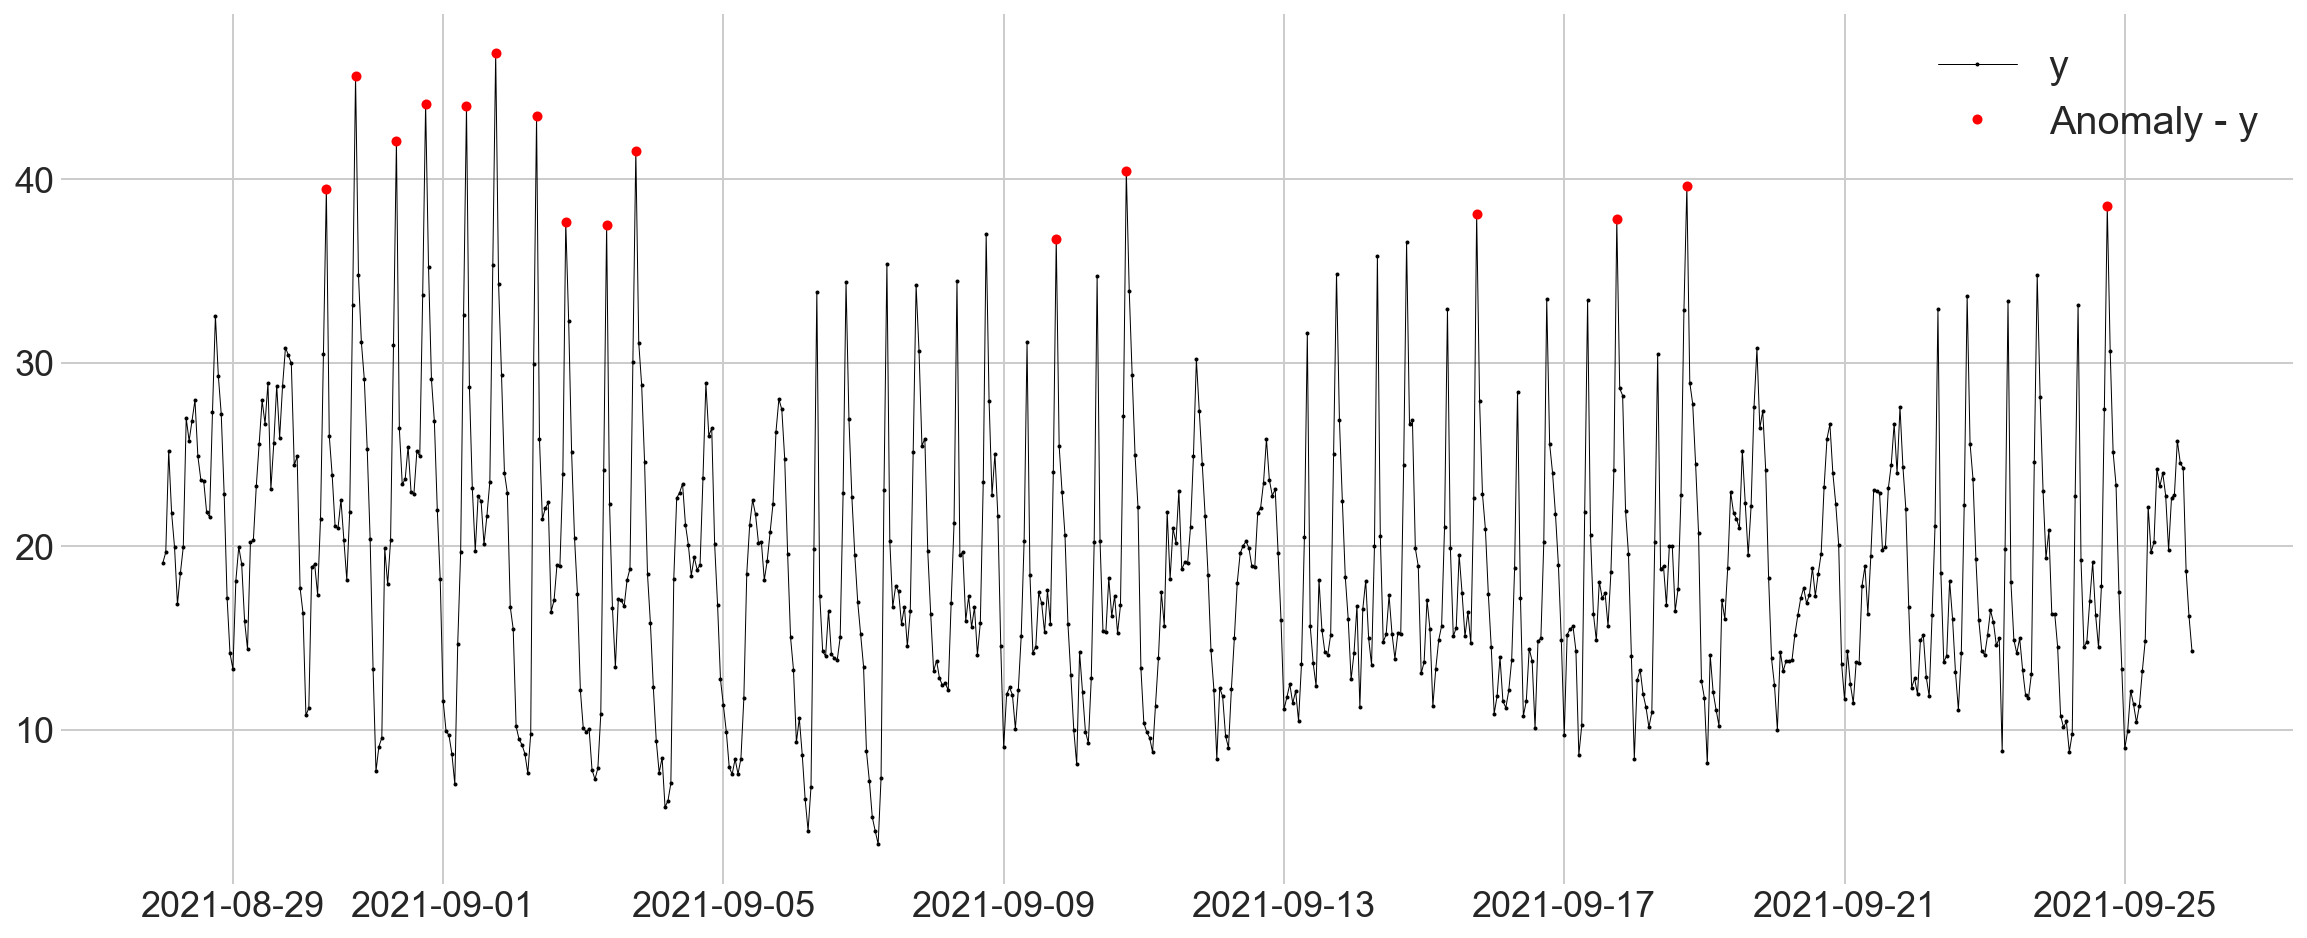

In [45]:
## 检测出异常值
seasonal_ad = SeasonalAD(freq = 10,c=1.5, side="both")
anomalies = seasonal_ad.fit_detect(tspredf2)
print("异常值数量:",anomalies.y.sum())
## 可视化出数据汇总异常值的情况
plot(tspredf2, anomaly=anomalies, ts_markersize=2, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=4,figsize=(20,8))

异常值数量: 34


[<AxesSubplot:>]

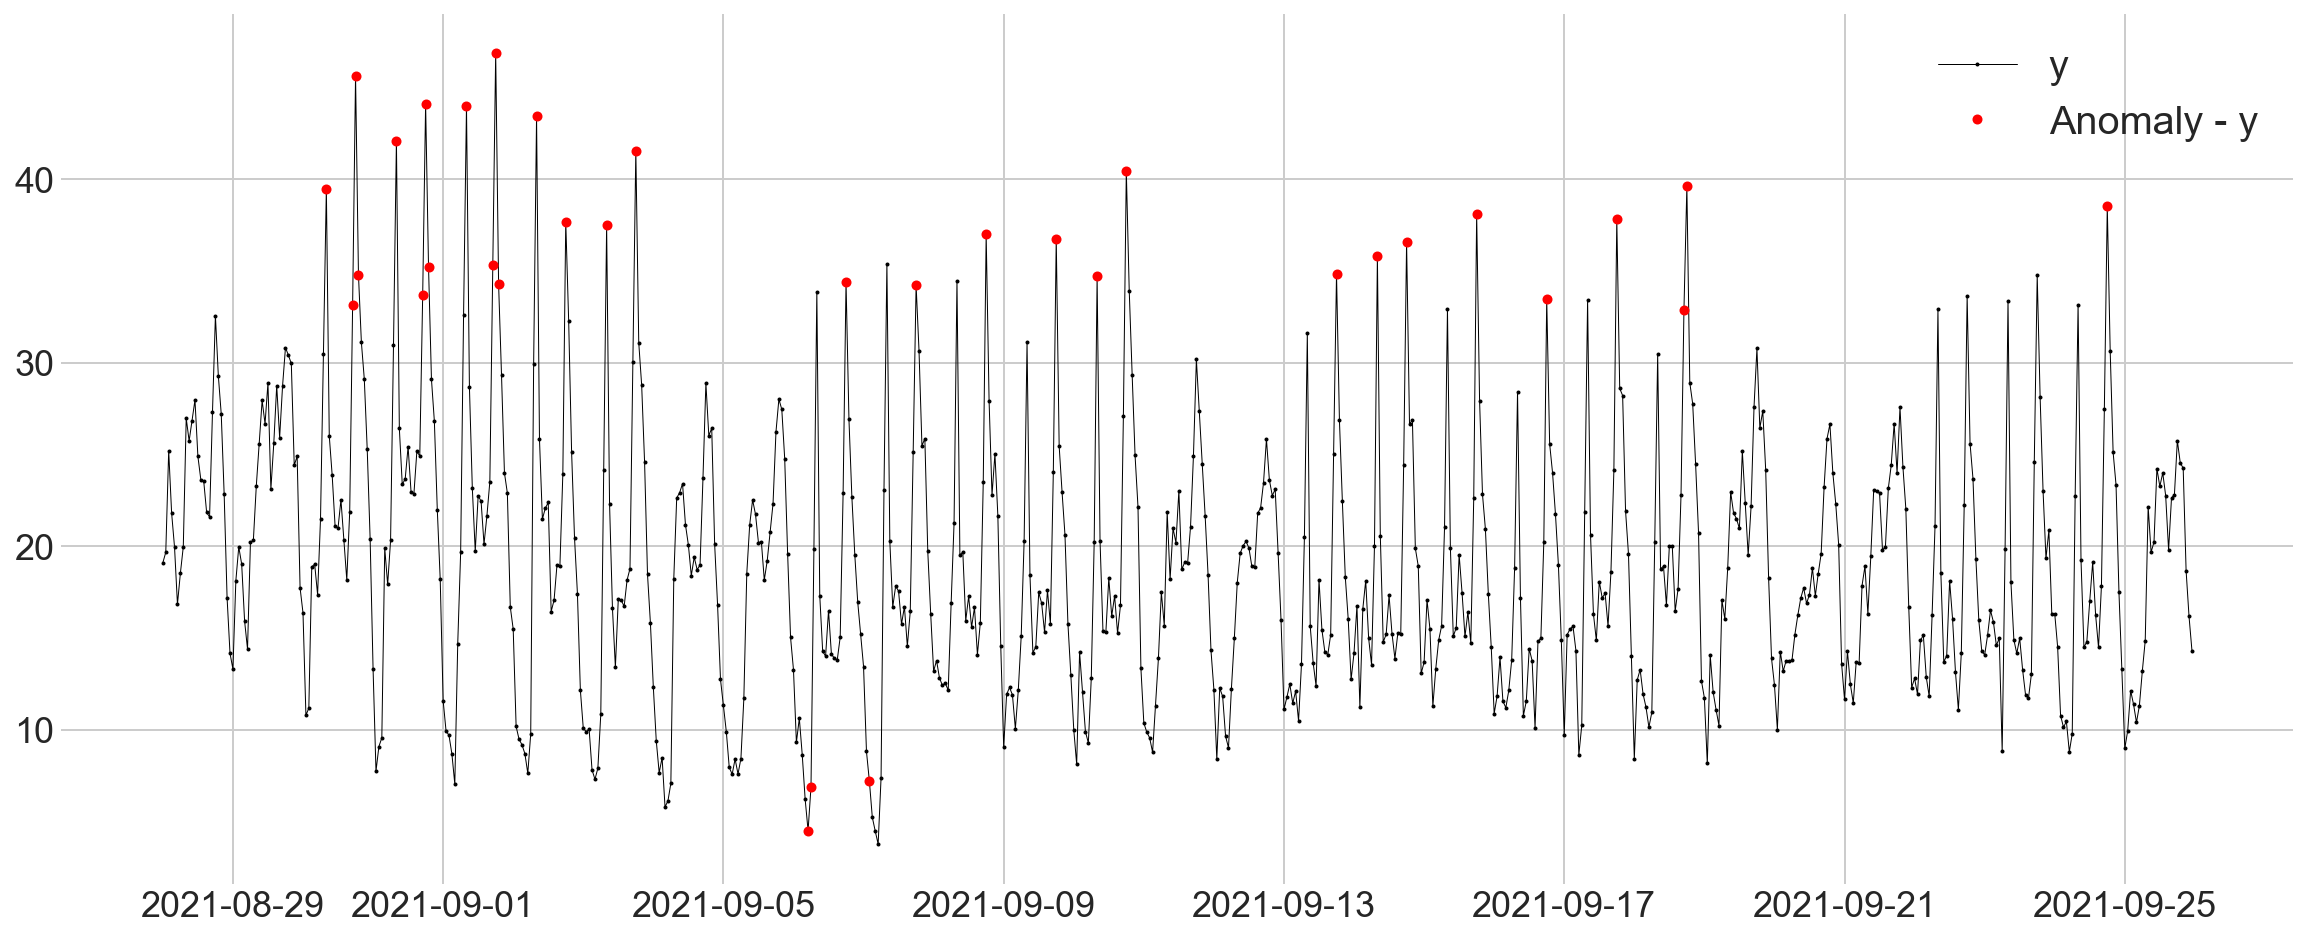

In [46]:
## 检测出异常值,调整不同的参数，获得不同的结果
seasonal_ad = SeasonalAD(freq = 30,c=1, side="both")
anomalies = seasonal_ad.fit_detect(tspredf2)
print("异常值数量:",anomalies.y.sum())
## 可视化出数据汇总异常值的情况
plot(tspredf2, anomaly=anomalies, ts_markersize=2, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=4,figsize=(20,8))

异常值数量: 0


[<AxesSubplot:>]

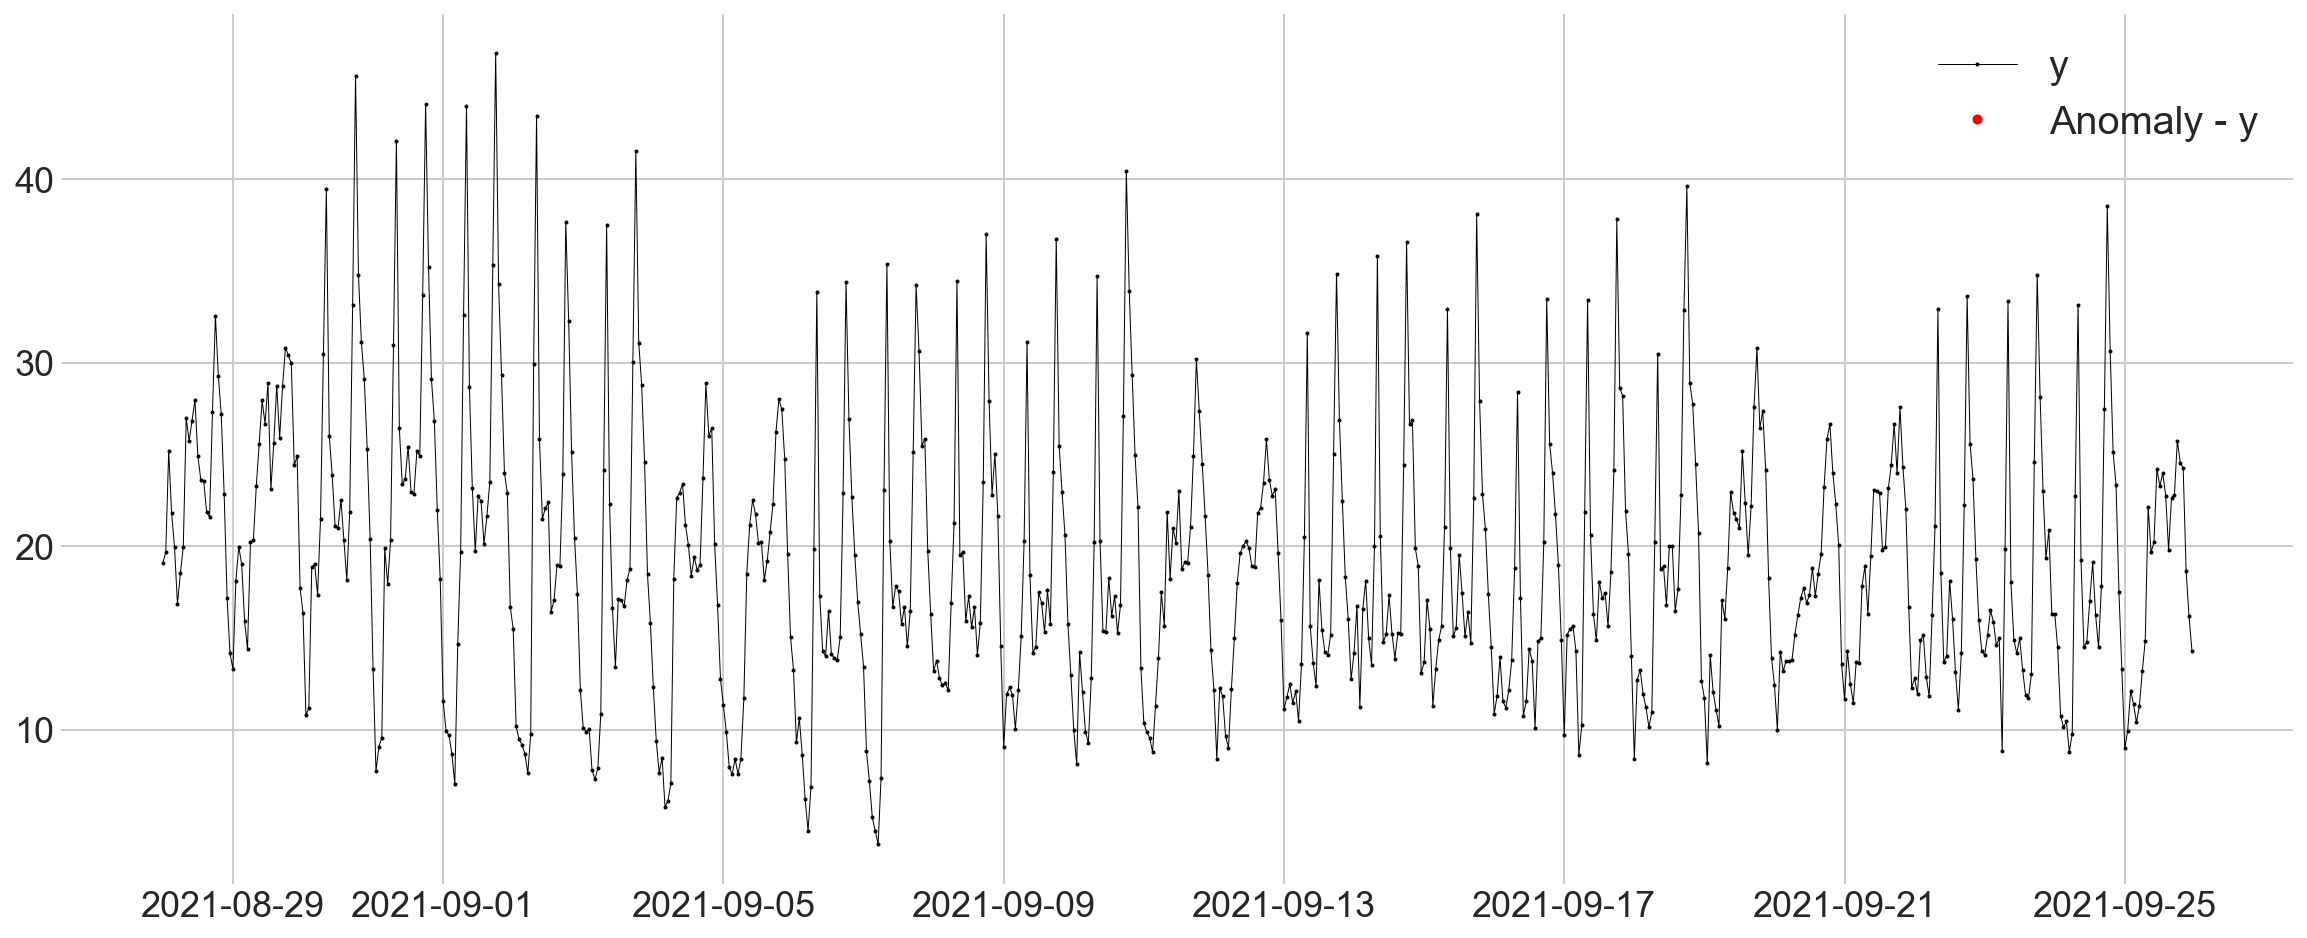

In [47]:
## 新的模型检测异常值
esd_ad = GeneralizedESDTestAD(alpha=0.1)
anomalies = esd_ad.fit_detect(tspredf2)
print("异常值数量:",anomalies.y.sum())
## 可视化出数据汇总异常值的情况
plot(tspredf2, anomaly=anomalies, ts_markersize=2, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=4,figsize=(20,8))

异常值数量: 5


[<AxesSubplot:>]

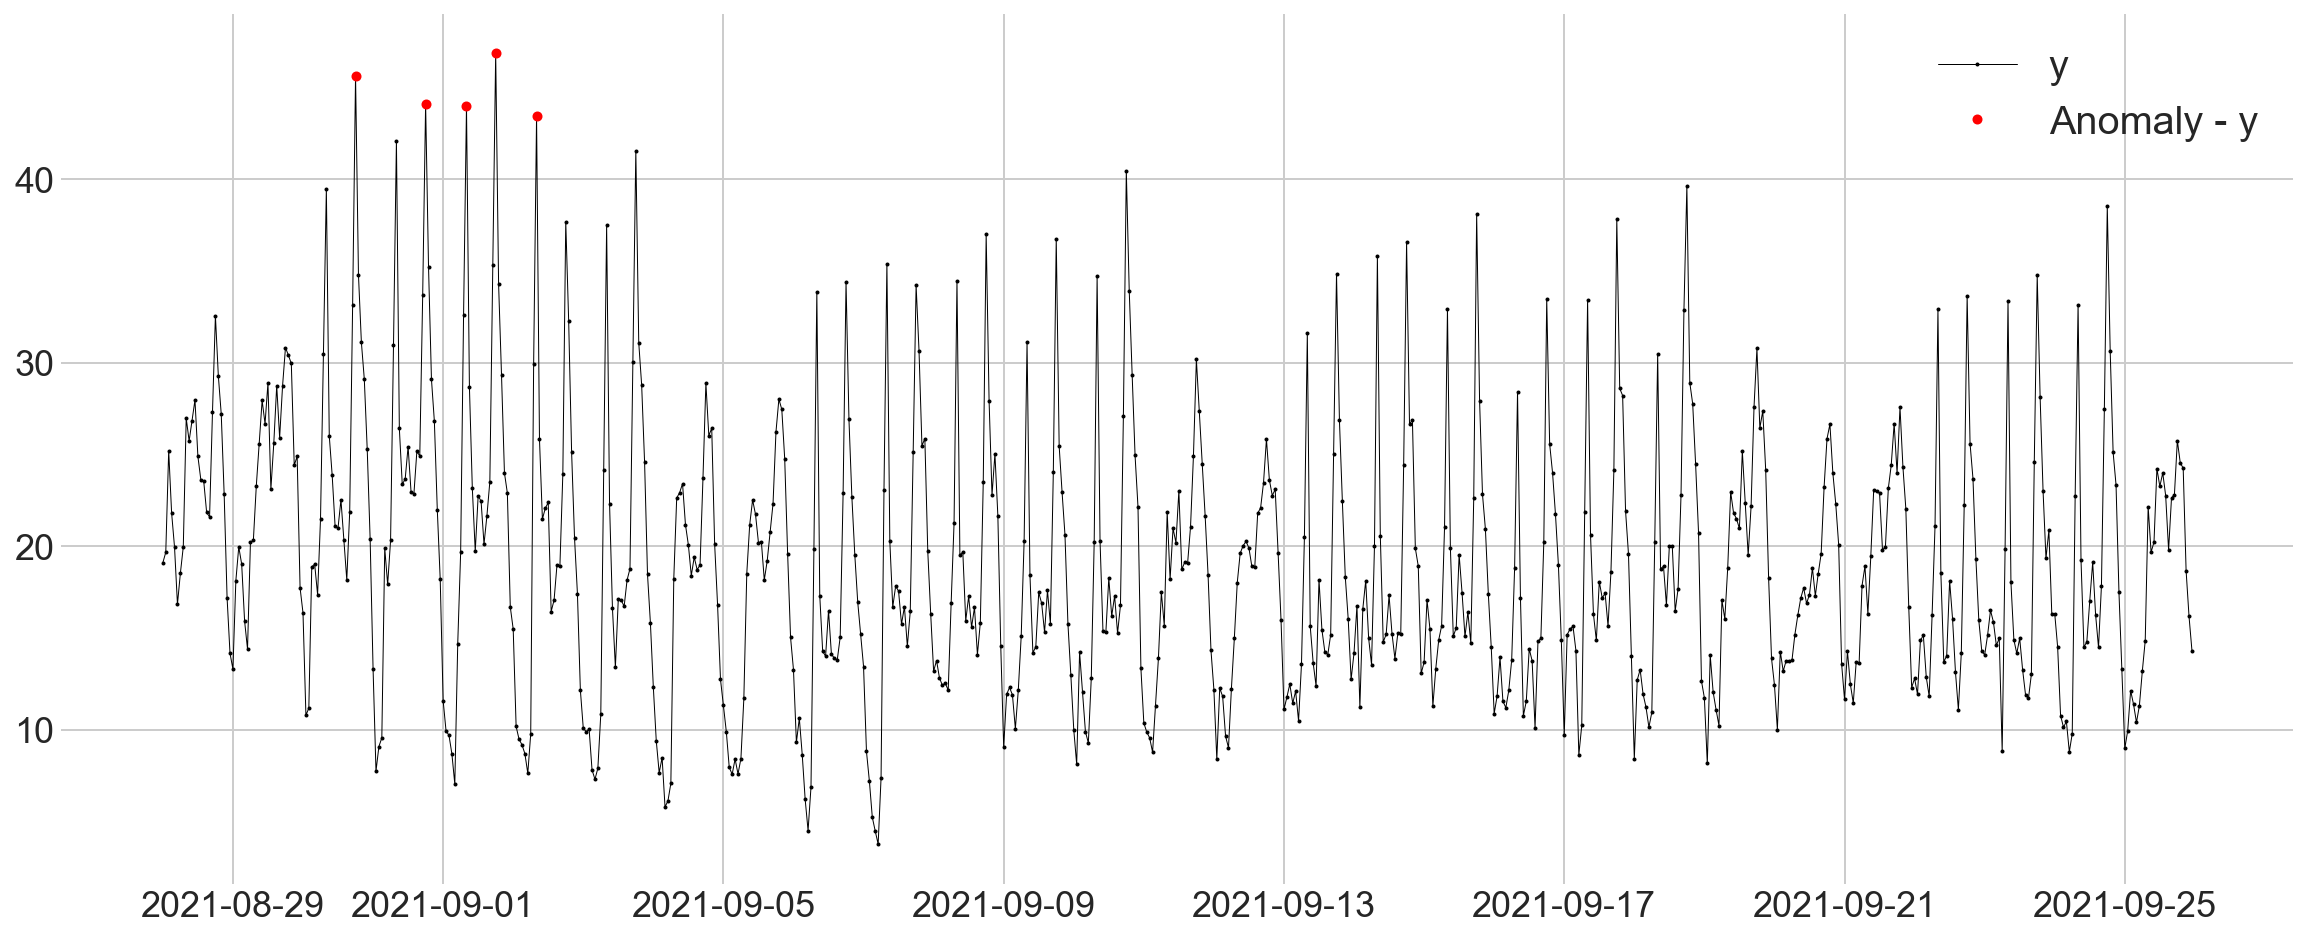

In [48]:
## 新的模型检测异常值
esd_ad = GeneralizedESDTestAD(alpha=0.5)
anomalies = esd_ad.fit_detect(tspredf2)
print("异常值数量:",anomalies.y.sum())
## 可视化出数据汇总异常值的情况
plot(tspredf2, anomaly=anomalies, ts_markersize=2, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=4,figsize=(20,8))

异常值数量: 7


[<AxesSubplot:>]

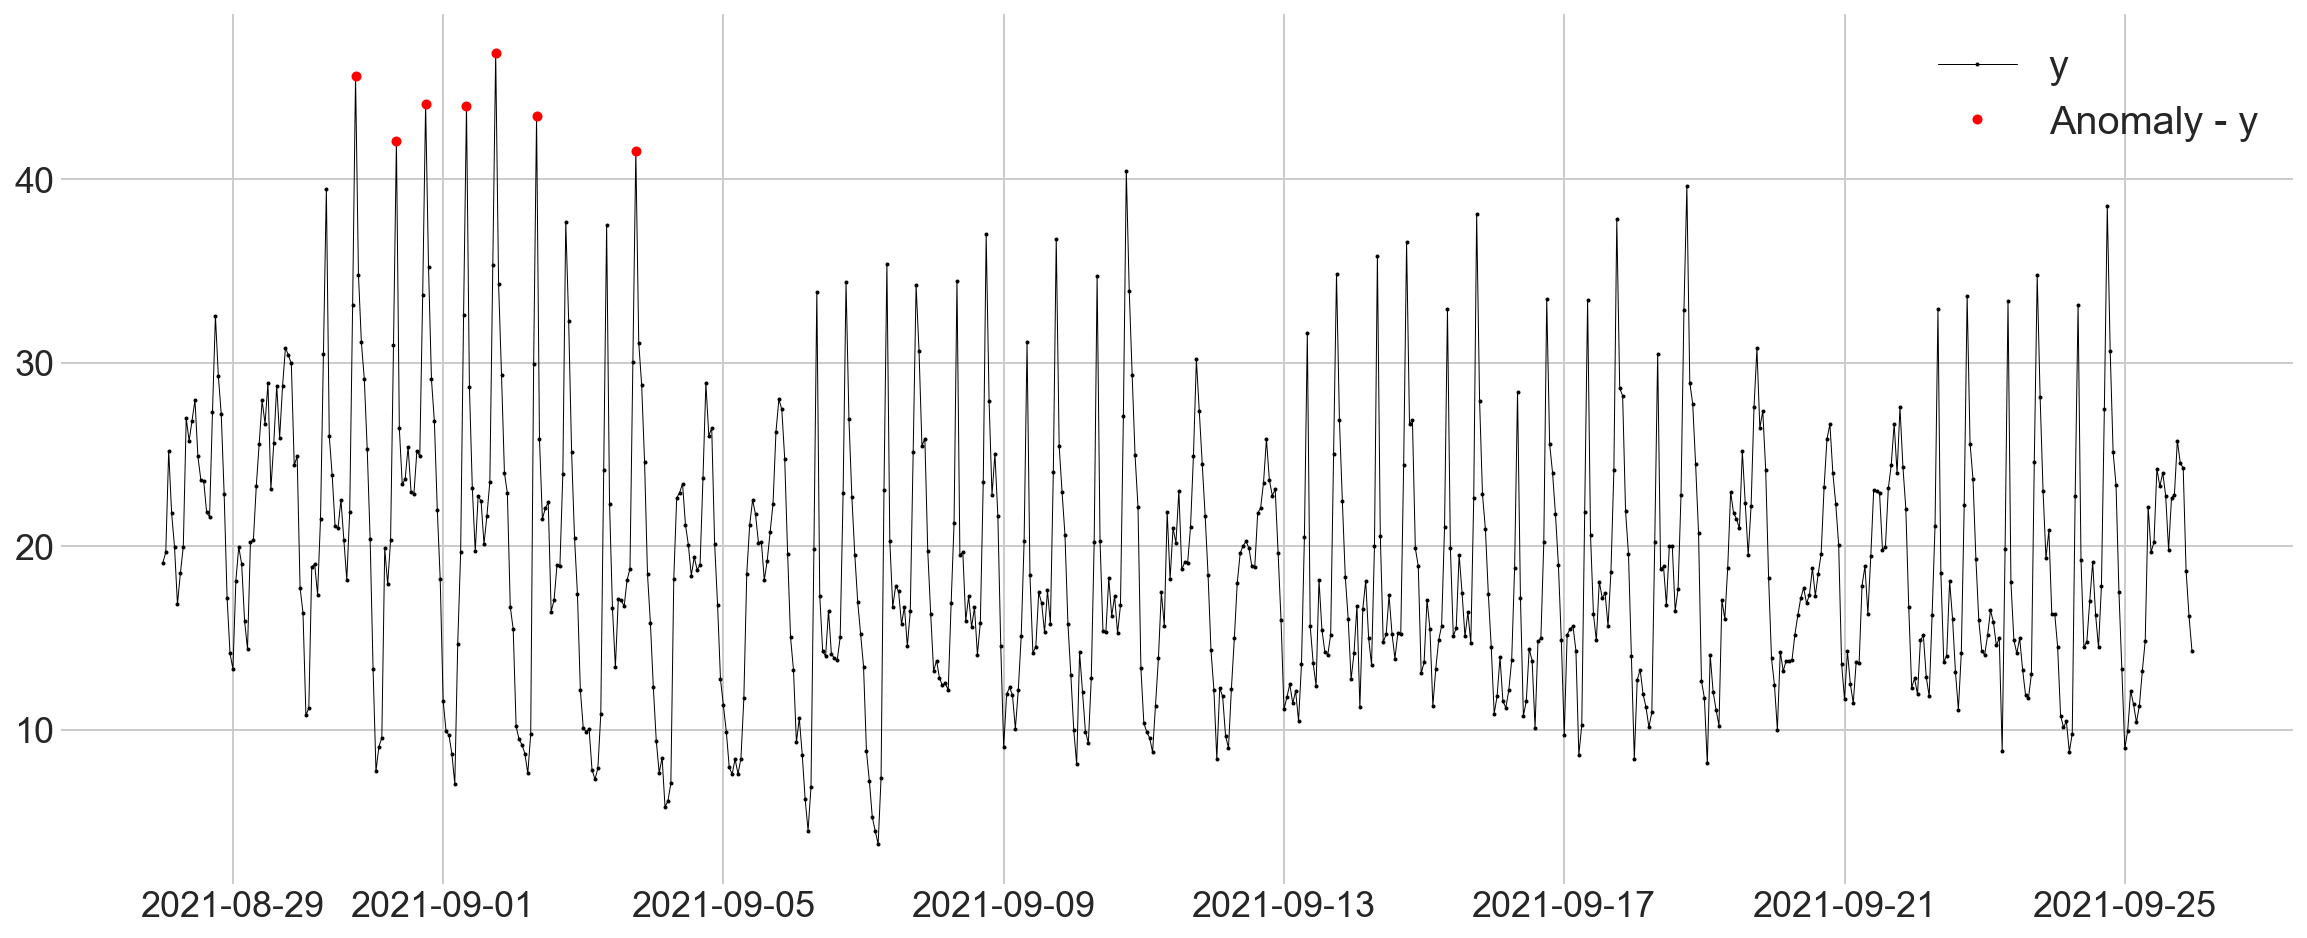

In [49]:
## 新的模型检测异常值
esd_ad = GeneralizedESDTestAD(alpha=1)
anomalies = esd_ad.fit_detect(tspredf2)
print("异常值数量:",anomalies.y.sum())
## 可视化出数据汇总异常值的情况
plot(tspredf2, anomaly=anomalies, ts_markersize=2, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=4,figsize=(20,8))

异常值数量: 46


[<AxesSubplot:>]

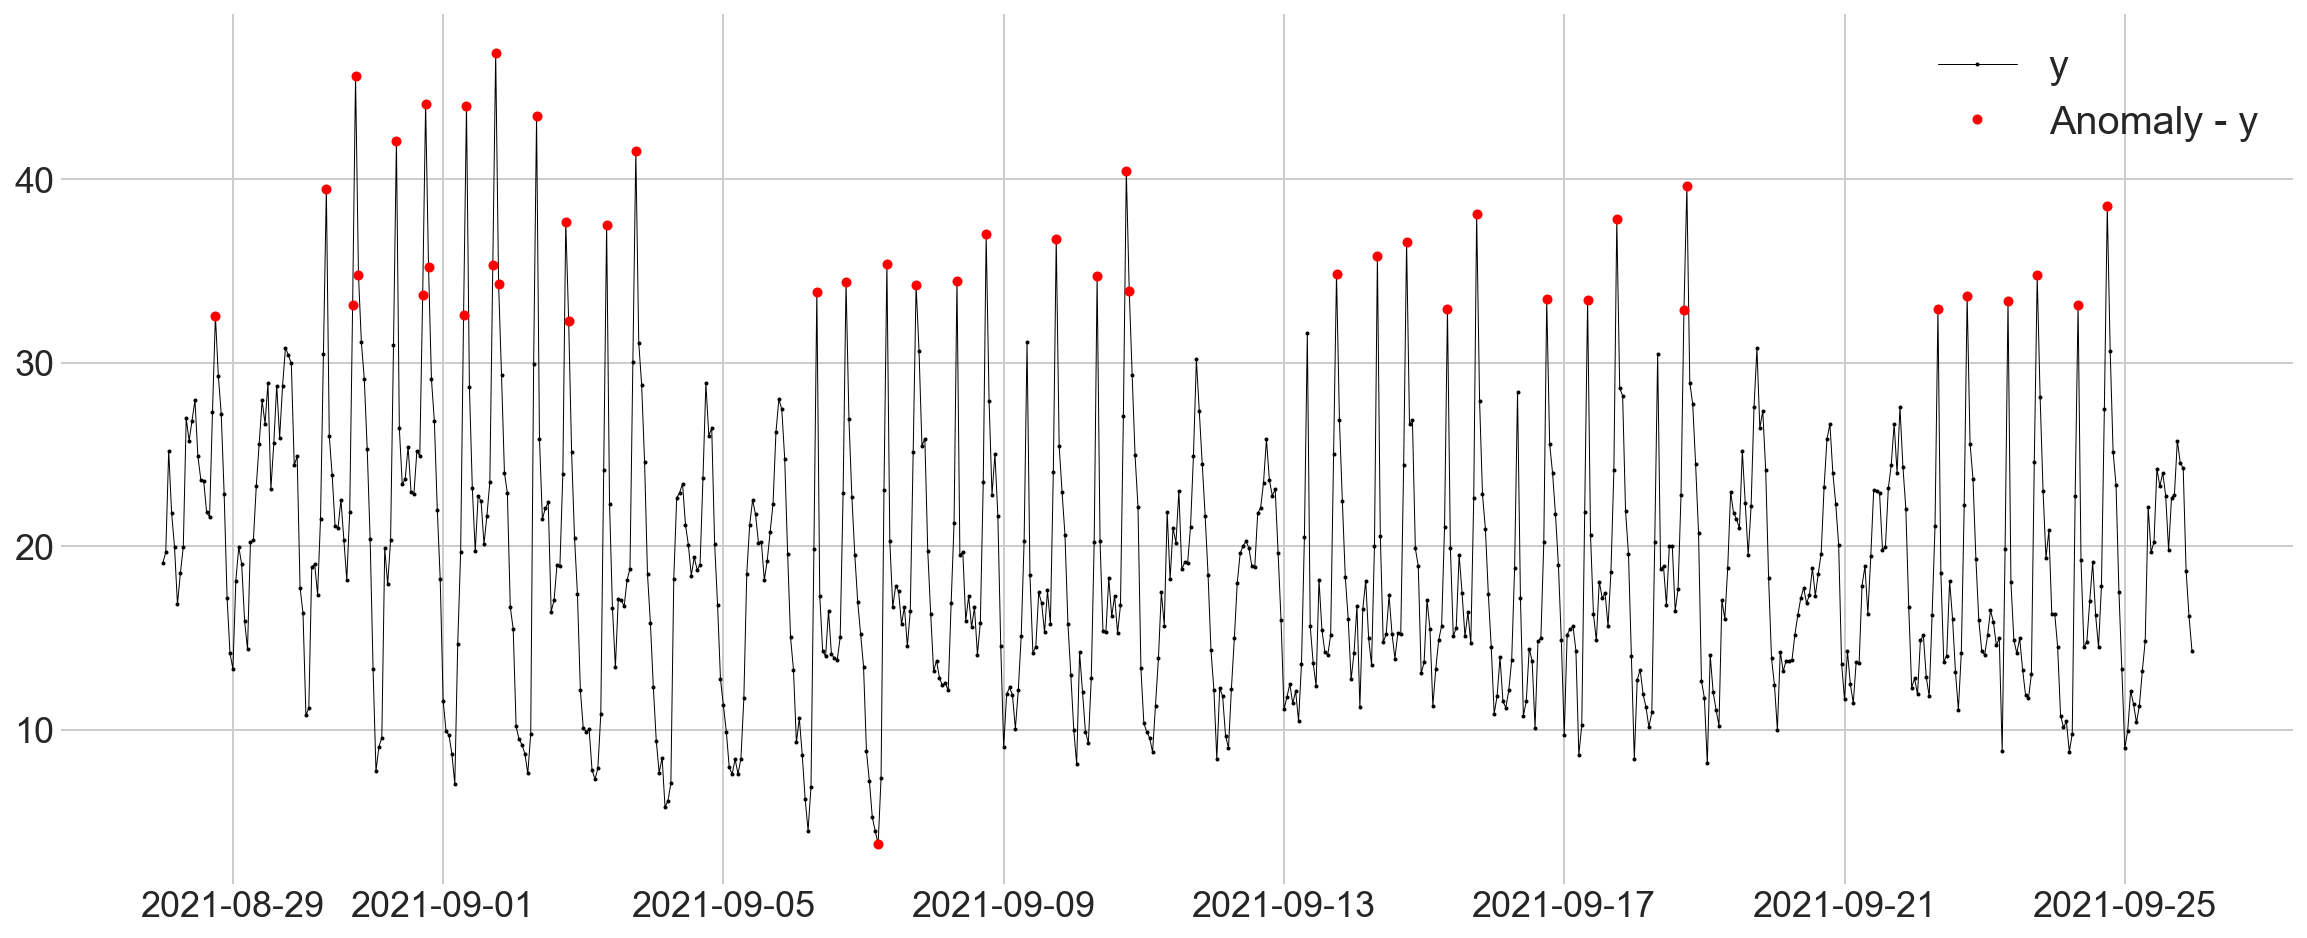

In [50]:
## 新的模型检测异常值
esd_ad = GeneralizedESDTestAD(alpha=10)
anomalies = esd_ad.fit_detect(tspredf2)
print("异常值数量:",anomalies.y.sum())
## 可视化出数据汇总异常值的情况
plot(tspredf2, anomaly=anomalies, ts_markersize=2, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=4,figsize=(20,8))